# 01 AssetAllocation at DQN, A2C, DDPG
手始めに，最も簡単と思われる資産配分問題を扱う．
最適資産配分の問題は本来的には連続的だが，強化学習は離散系のアルゴリズムもあるので，この場合は各資産に対して0〜1.0までの0.1ずつの10段階で離散化するものとする．尚，資産配分は本来合計で1になっていなければならないが，方策を作る手間を避けるため，一旦は0〜1で設定した後に正規化することとした．このため，厳密には解は一意的になっていない．

環境名がCAPMになっているが，単に当初の名前がそのまま残っているだけである．

---
## 0. Setup

In [1]:
import numpy as np
np.set_printoptions(precision=8)  # 数値桁数を指定．
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

import importlib
import itertools

import sys
sys.path.append('../../RLPack')

In [2]:
# Google Colab用の設定．
if False:
    from google.colab import drive
    drive.mount('/content/gdrive')
    sys.path.append('/content/gdrive/My Drive/Colab Notebooks/RLPack')

---
## 1. Environment

In [3]:
import Env_CAPM
importlib.reload(Env_CAPM)

<module 'Env_CAPM' from '/media/deepstation/strage01/Actuary/2019/20191028_AA_ALL/Env_CAPM.py'>

---
## 2. At 2 Assets

100%|██████████| 1000/1000 [00:00<00:00, 24167.42it/s]


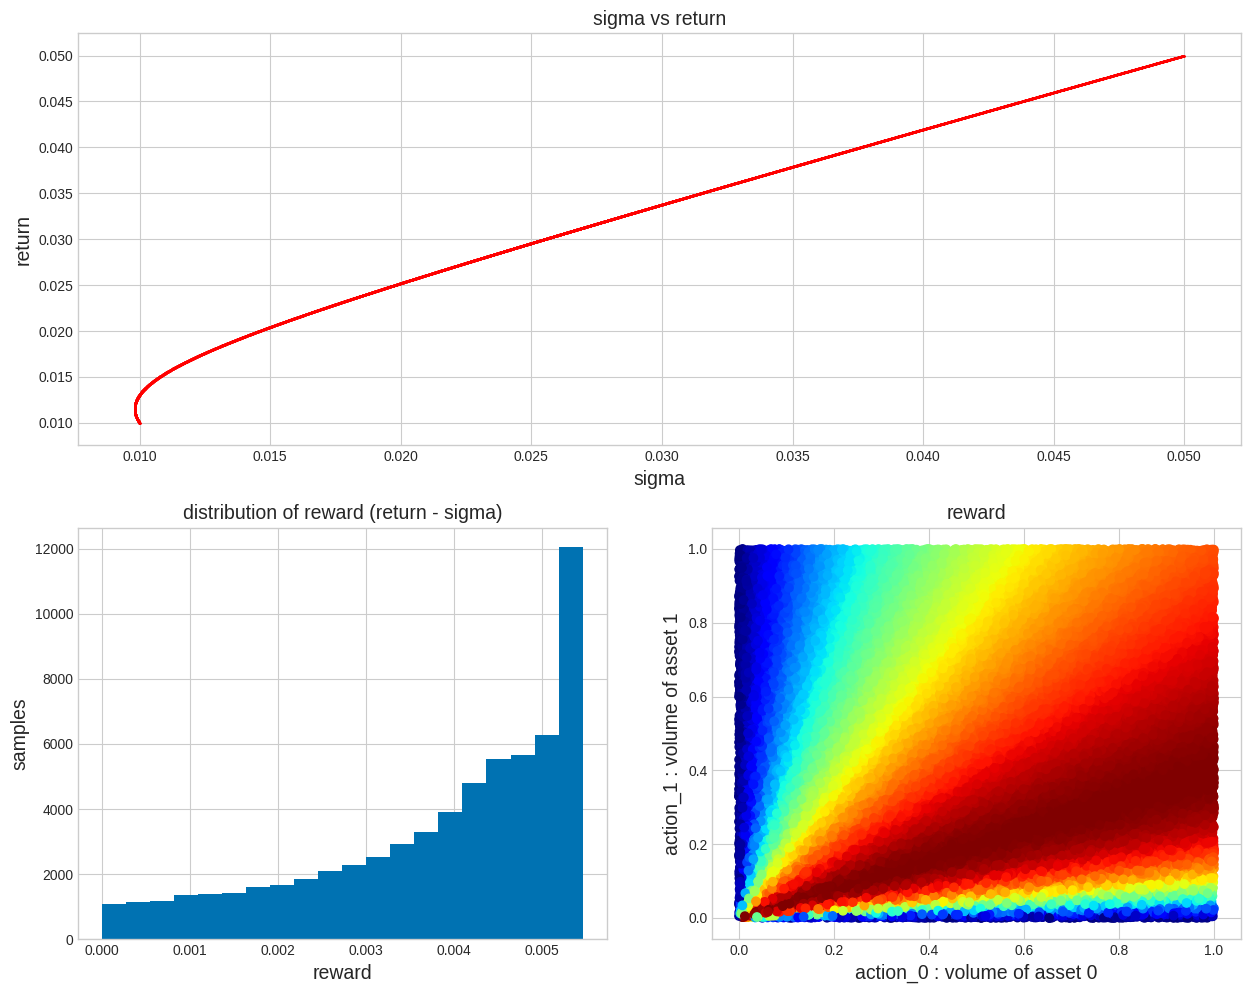

on sample    : maximum reward=0.005457 at action=[0.693 0.272], mu=0.021269, sigma=0.015811
on optimizer : maximum reward=0.005457 at action=[0.718 0.282], mu=0.021268, sigma=0.015811


In [4]:
# 2資産の場合
returns = [0.01, 0.05]
sigmas = [0.01, 0.05]

env = Env_CAPM.CAPM(returns=returns, sigmas=sigmas)
env.show_simulation()

In [5]:
n_trials = 5
n_steps = 10000
df = pd.DataFrame()

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
W1029 00:36:06.810800 140606982829888 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1029 00:36:06.811598 140606982829888 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1029 00:36:06.814739 

lr=0.0001, alpha=1.0
start testing... :  2019-10-29 00:36:06.889563
start trial 1/5 trial...


W1029 00:36:07.222686 140606982829888 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

  0%|          | 0/10000 [00:00<?, ?it/s]

start trial 2/5 trial...


  0%|          | 0/10000 [00:00<?, ?it/s]

start trial 3/5 trial...


100%|██████████| 10000/10000 [01:02<00:00, 154.74it/s]


start trial 4/5 trial...


100%|██████████| 10000/10000 [01:05<00:00, 144.50it/s]


start trial 5/5 trial...


100%|██████████| 10000/10000 [01:08<00:00, 139.86it/s]


end testing... :  2019-10-29 00:41:20.976299
loss and reward history


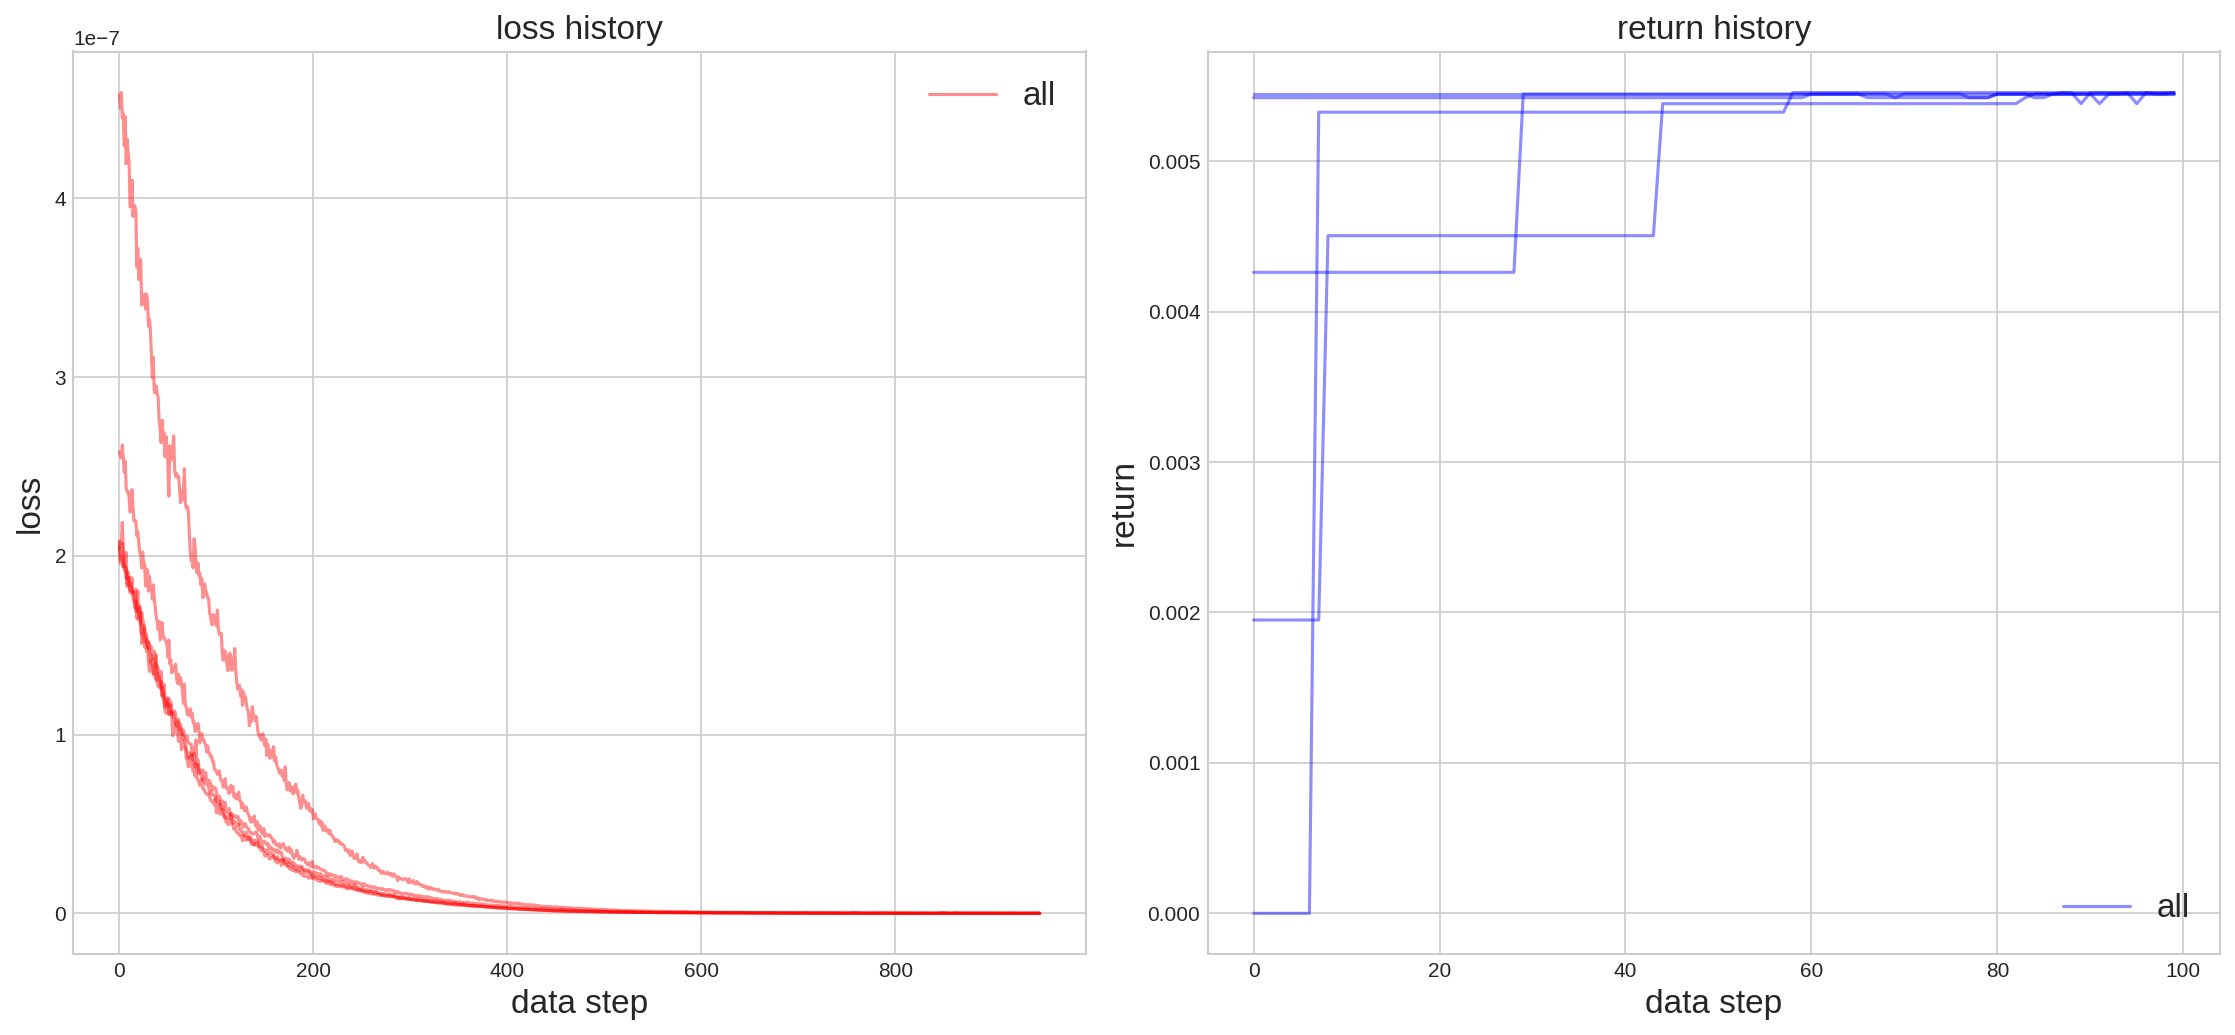

acquired action
action =  [52 52 52 52 52 52 52 52 52 52]
return [0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005]
param distribution in model


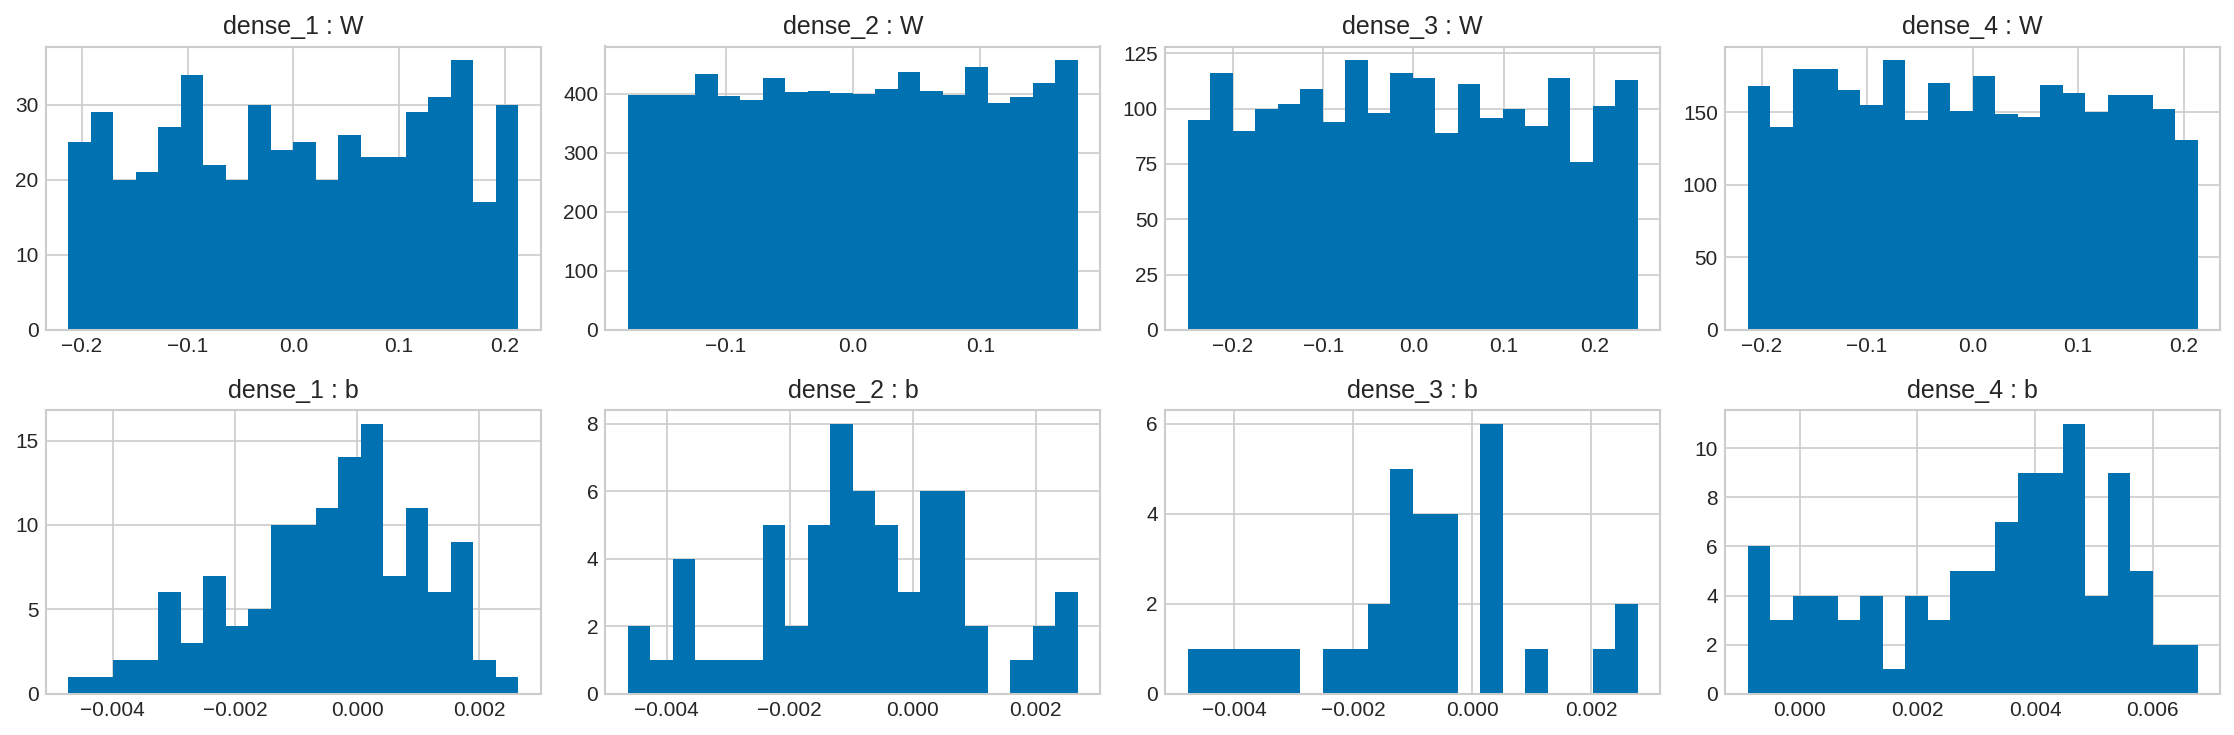

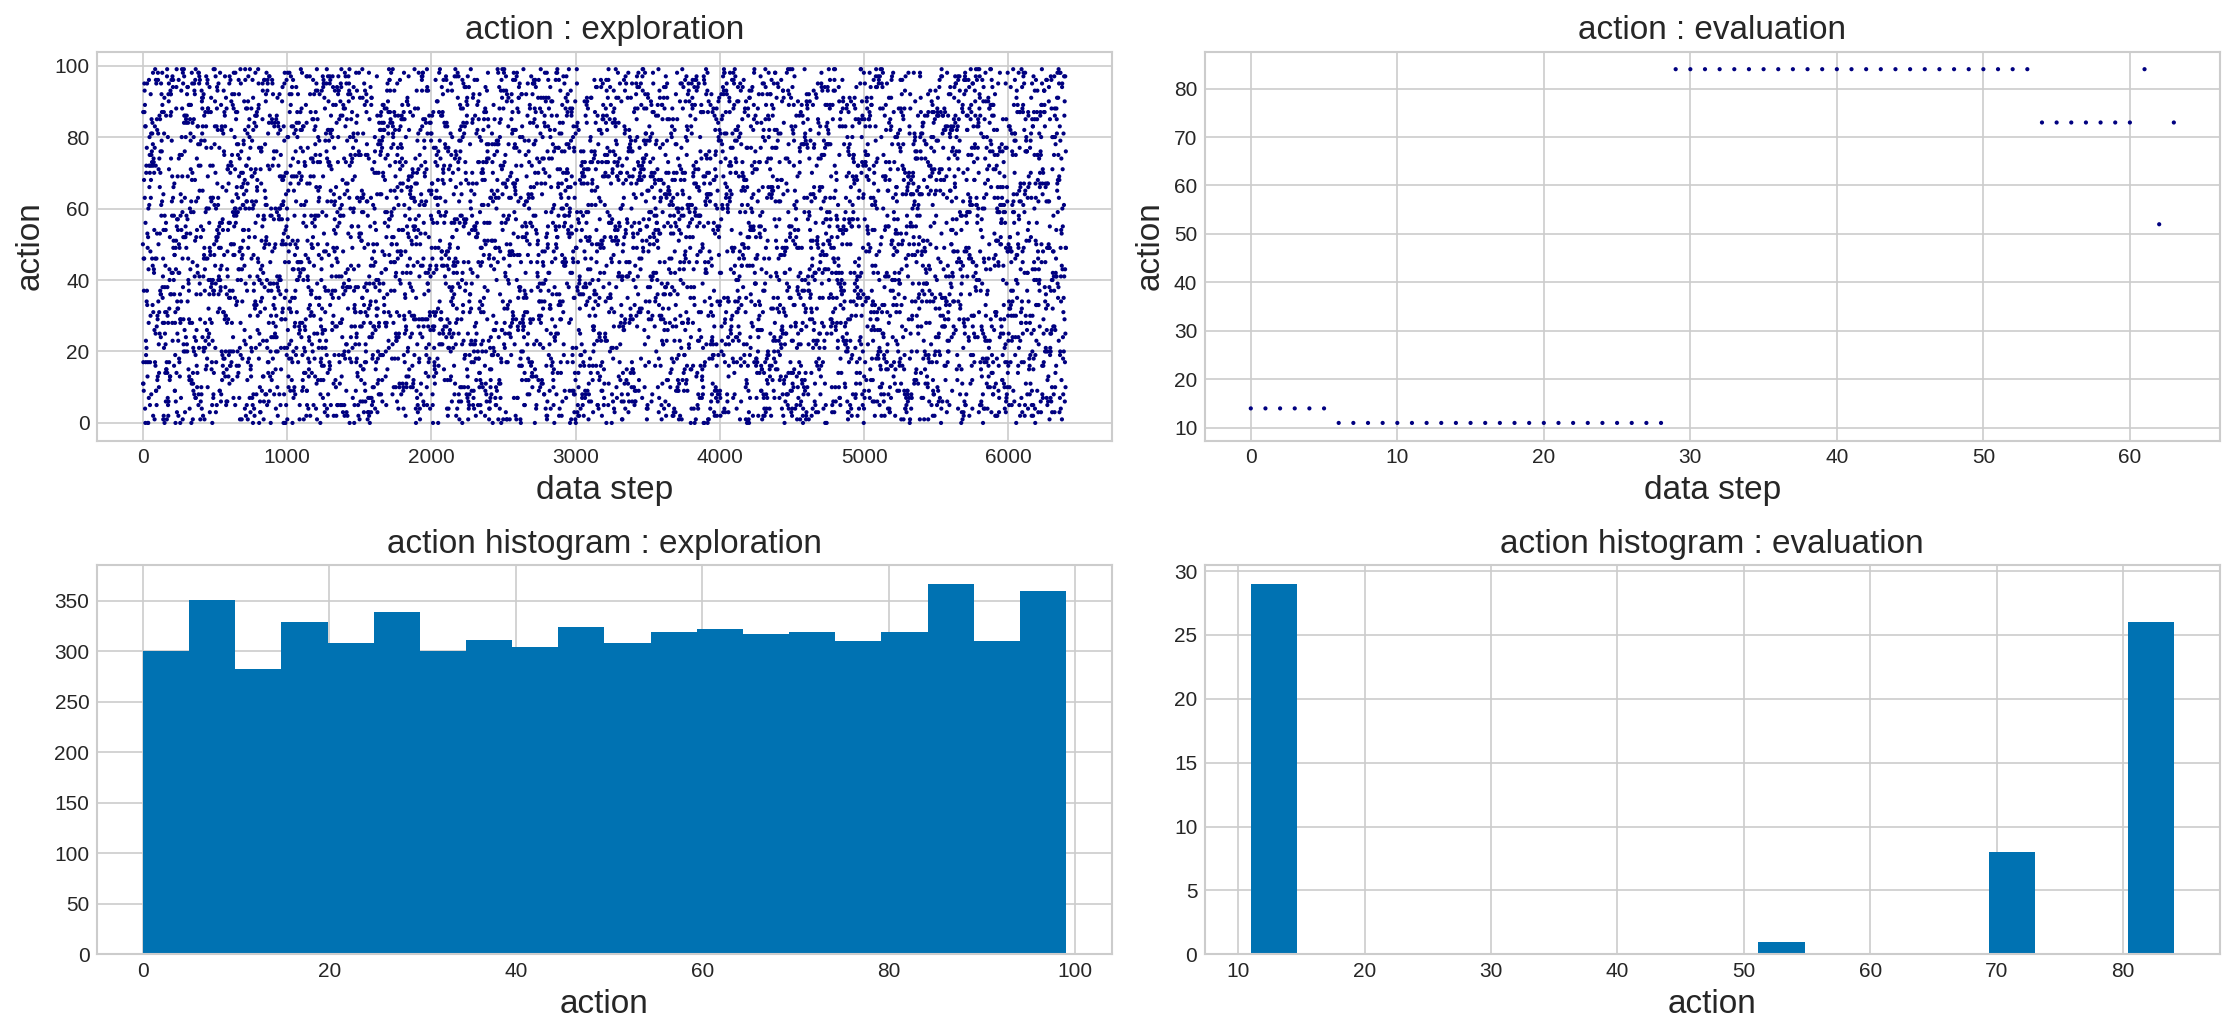

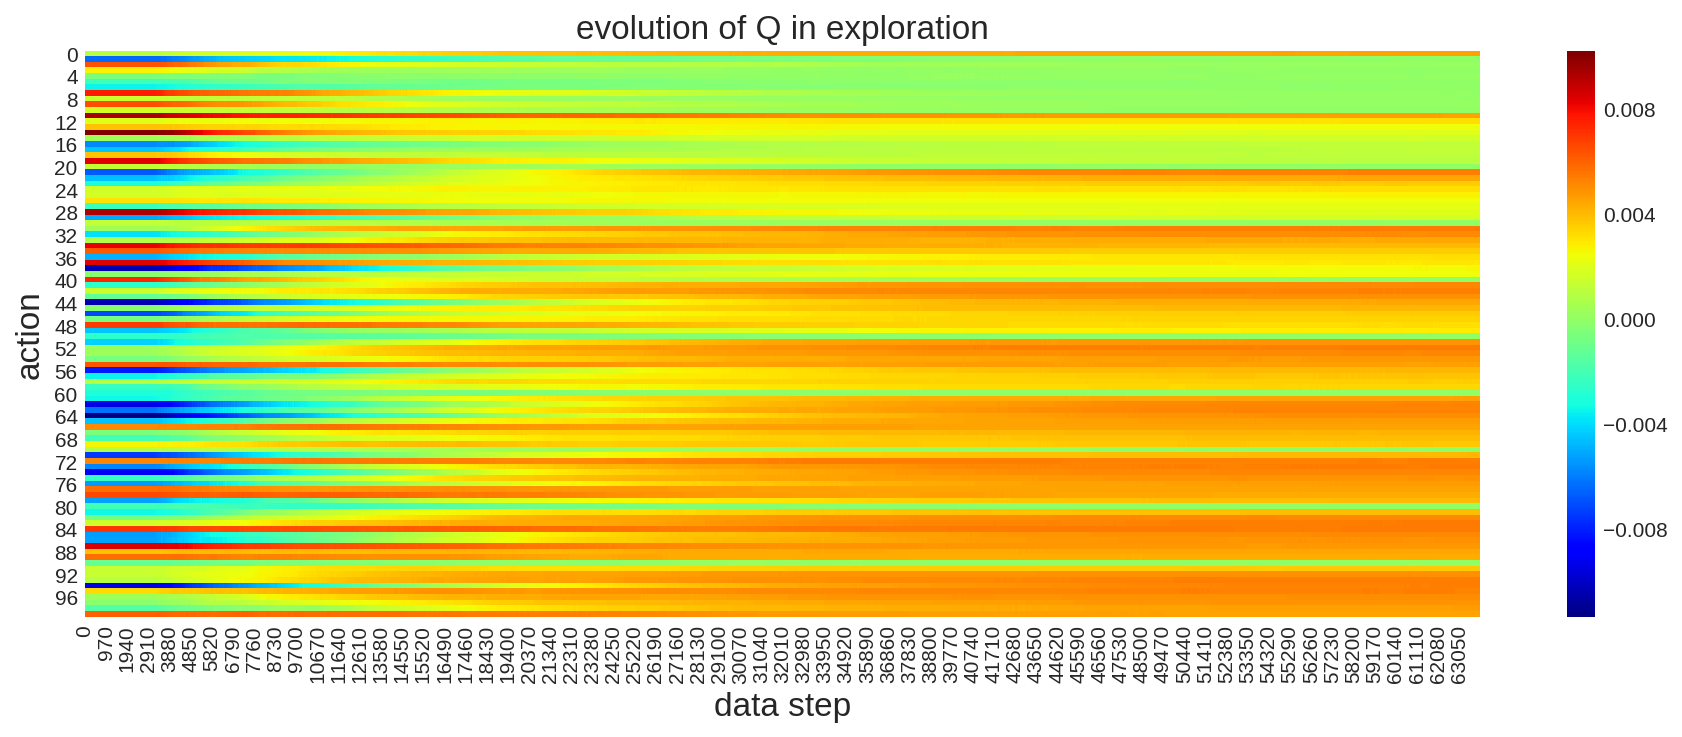

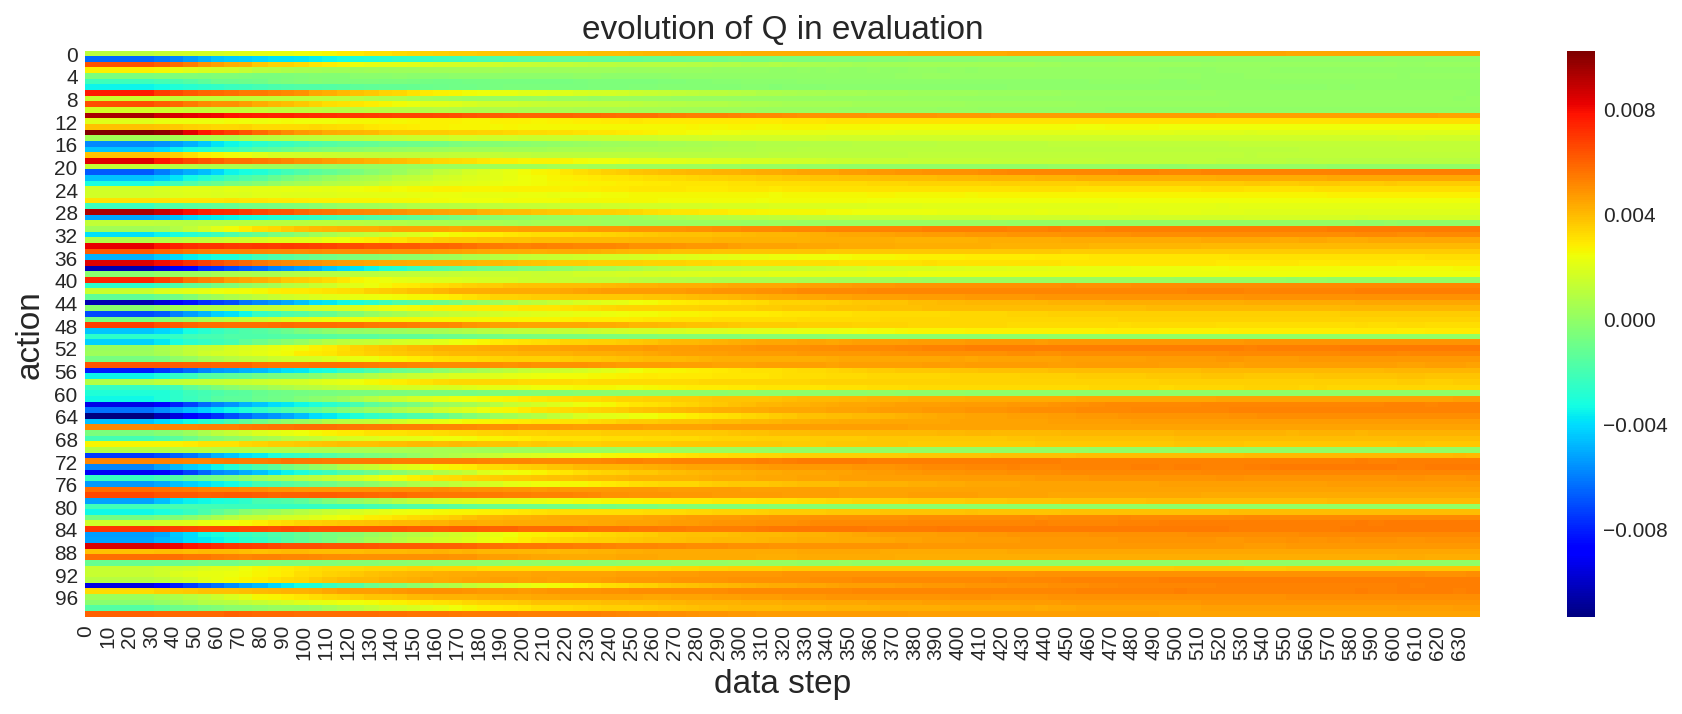

In [6]:
import DQN  # original DRL code
importlib.reload(DQN)
from keras import optimizers

env = Env_CAPM.CAPM(returns=returns, sigmas=sigmas, 
                      action_default_mode='discrete')

model = DQN.gen_model(
    input_shapes=env.shapes(), n_outputs=10 ** env.n_assets, 
    hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0,
    duel=False, duel_value_dim=16, duel_advantage_dim=16
)

#df = pd.DataFrame()
for lr, alpha in itertools.product([1e-4,], [1.0,]):
    print('======================================================')
    print('lr={}, alpha={}'
          .format(lr, alpha))
    
    tester = DQN.Tester(env, model, name='DQN_01')
    #n_trials = 3
    #n_steps = 10000
    tester.test(
        n_trials=n_trials, n_steps=n_steps,
        training_interval=10, n_batches=10, batch_size=256, alpha=alpha, 
        target_update_interval=20, doubleQ=False,
        gamma=1.0, optimizer=optimizers.Adam(lr, clipnorm=10),
        epsilon_start=1.0, epsilon_end=1.0, epsilon_interval=n_steps,
        boltzmann=False, 
        verbose=False, verbose_interval=10, evaluate_interval=100, 
        get_log=True)

    viz = DQN.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:np.ravel(x[0][:, 0]),data_span=100,  
                               cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['alpha'] = alpha
        df_temp['Agent'] = 'DQN'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

lr=0.0001, n_advantages=1, mult_critic=0.1, mult_entropy=0.0001
start testing... :  2019-10-29 00:41:31.415773
start 0/5 th trial...


  0%|          | 0/10000 [00:00<?, ?it/s]W1029 00:41:32.305335 140606982829888 deprecation.py:323] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 10000/10000 [00:28<00:00, 353.13it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [00:29<00:00, 339.98it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [00:30<00:00, 324.89it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [00:31<00:00, 312.56it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [00:33<00:00, 300.30it/s]


end testing... :  2019-10-29 00:44:08.295777
loss and reward history


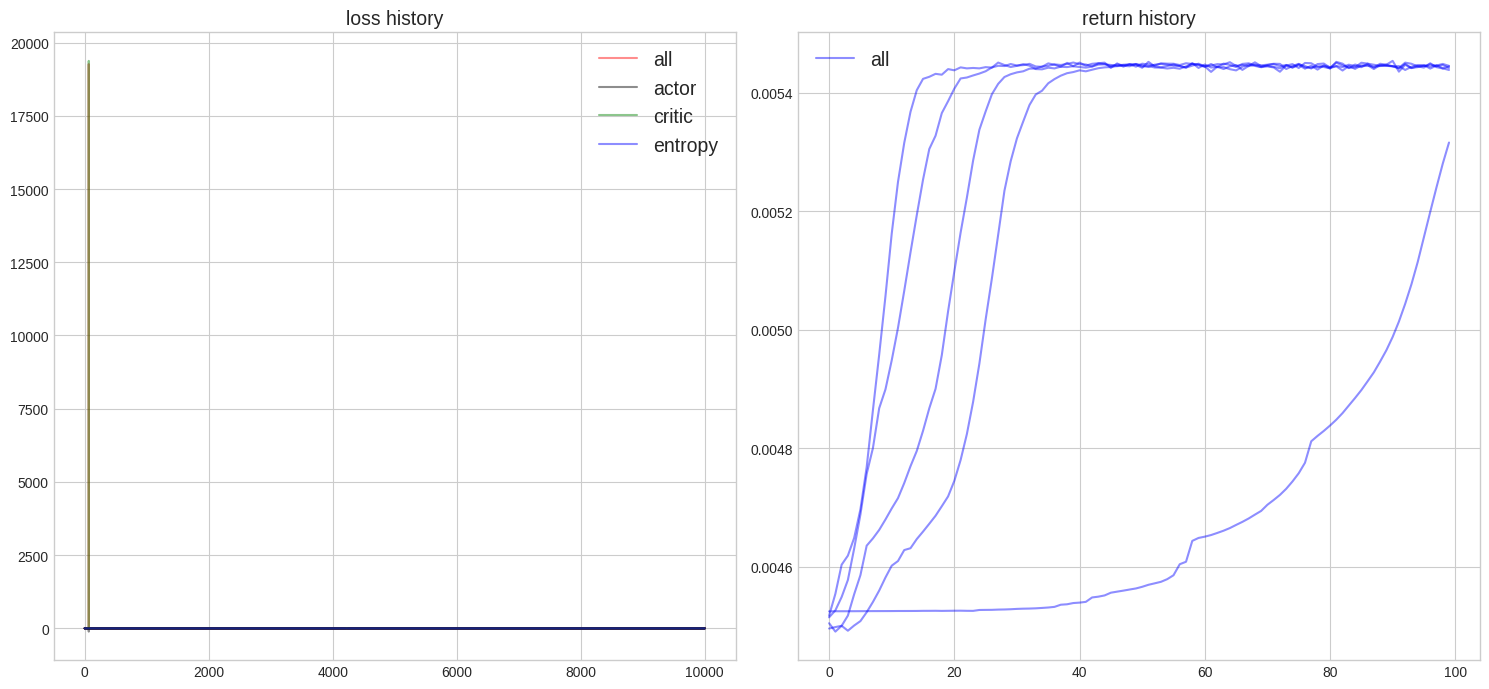

acquired action
action =  [0.842 0.463 0.842 0.463 0.842 0.463 0.842 0.463 0.842 0.463]
return [0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005]
param distribution in model


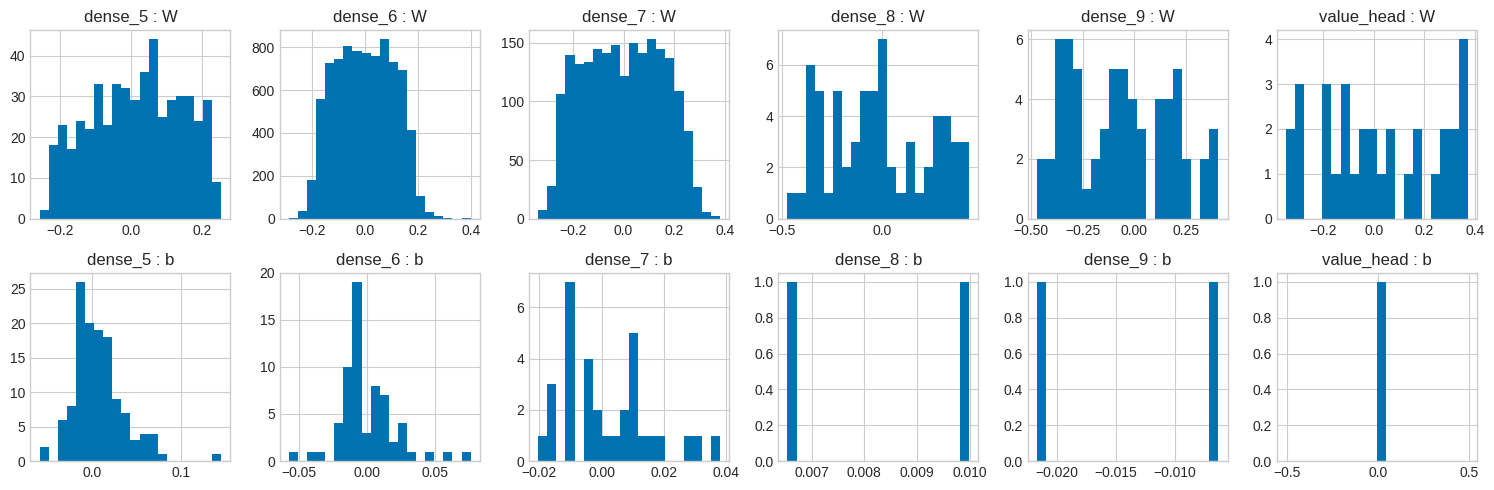

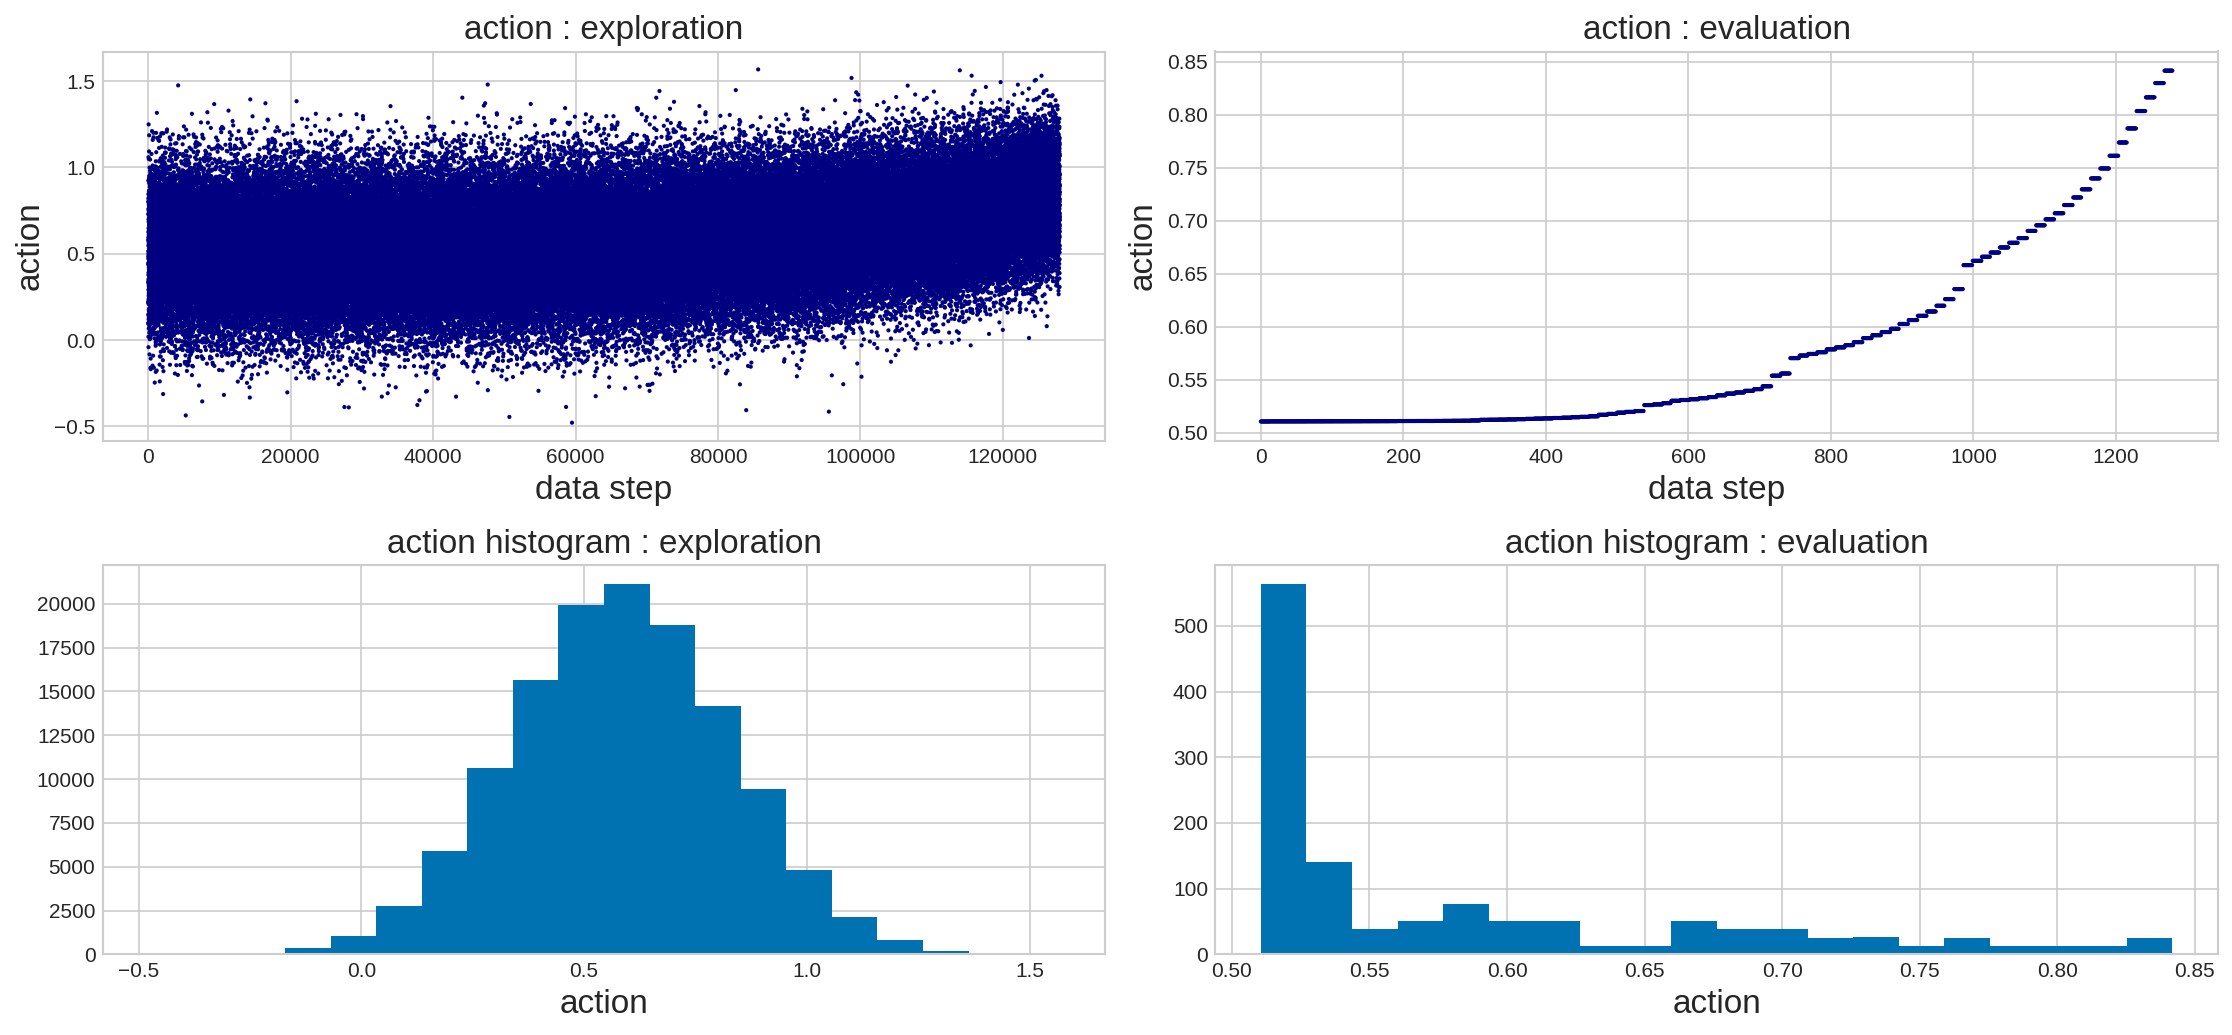

In [7]:
import A2C_continuous  # original DRL code
from keras import optimizers

env = Env_CAPM.CAPM(returns=returns, sigmas=sigmas, 
                      action_default_mode='continuous')

mu_min = 0.0
mu_max = 1.0
sigma_max = (mu_max - mu_min) / 3

model = A2C_continuous.gen_model(input_shapes=env.shapes(), n_outputs=env.n_assets, \
                                 hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, \
                                mu_min=mu_min, mu_max=mu_max, 
                                va_min=(0.00001)**2, va_max=sigma_max**2, 
                                input_reg=False, input_min=0, input_max=1)

#df = pd.DataFrame()
for lr, n_advantages, mult_critic, mult_entropy in itertools.product(
    [1e-4,], [1,], [0.1,], [0.0001,]):
    print('======================================================')
    print('lr={}, n_advantages={}, mult_critic={}, mult_entropy={}'
          .format(lr, n_advantages, mult_critic, mult_entropy))

    tester = A2C_continuous.Tester(env, model, name='A2C_01',
                                   val_min=mu_min-3*sigma_max, val_max=mu_max+3*sigma_max)
    #n_trials = 3
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps, n_advantages=n_advantages,
               gamma=1.0, optimizer=optimizers.Adam(lr=lr),
               mult_actor=1.0, mult_critic=mult_critic, mult_entropy=mult_entropy,
               verbose=False, verbose_interval=100, evaluate_interval=100, 
               get_log=True)

    viz = A2C_continuous.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                           cmap='jet', alpha=1.0, s=1.0)

    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['n_advantages'] = n_advantages
        #df_temp['mult_critic'] = mult_critic
        #df_temp['mult_entropy'] = mult_entropy
        df_temp['Agent'] = 'A2C'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

lr_p=0.0001, lr_v=0.001, boltzmann=False, sigma_end=1.0, tau_end=1
start testing... :  2019-10-29 00:44:14.272280
start 0/5 th trial...


100%|██████████| 10000/10000 [03:29<00:00, 47.85it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [03:36<00:00, 39.70it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [03:40<00:00, 45.40it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [03:48<00:00, 33.40it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [03:57<00:00, 42.30it/s]


end testing... :  2019-10-29 01:03:02.171109
loss and reward history


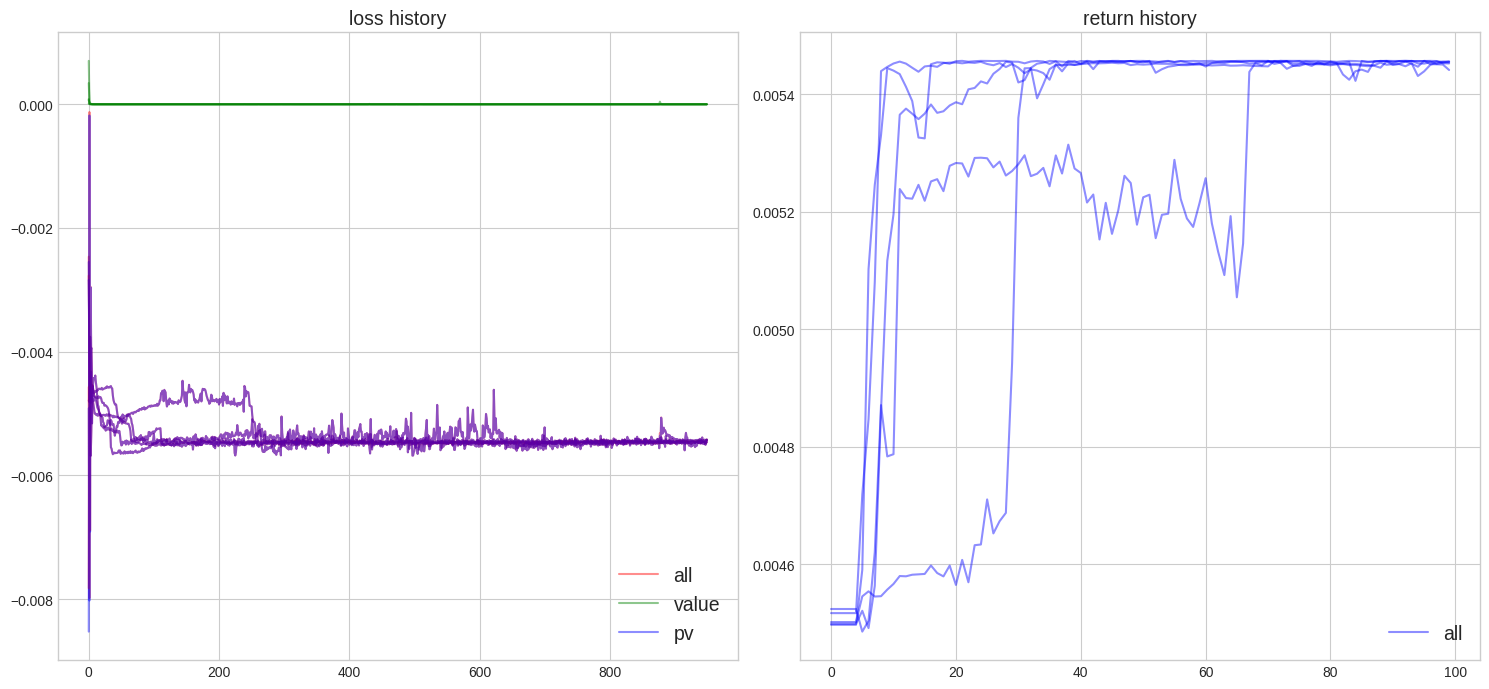

acquired action
action =  [0.535 0.198 0.535 0.198 0.535 0.198 0.535 0.198 0.535 0.198]
return [0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005]
param distribution in model_policy


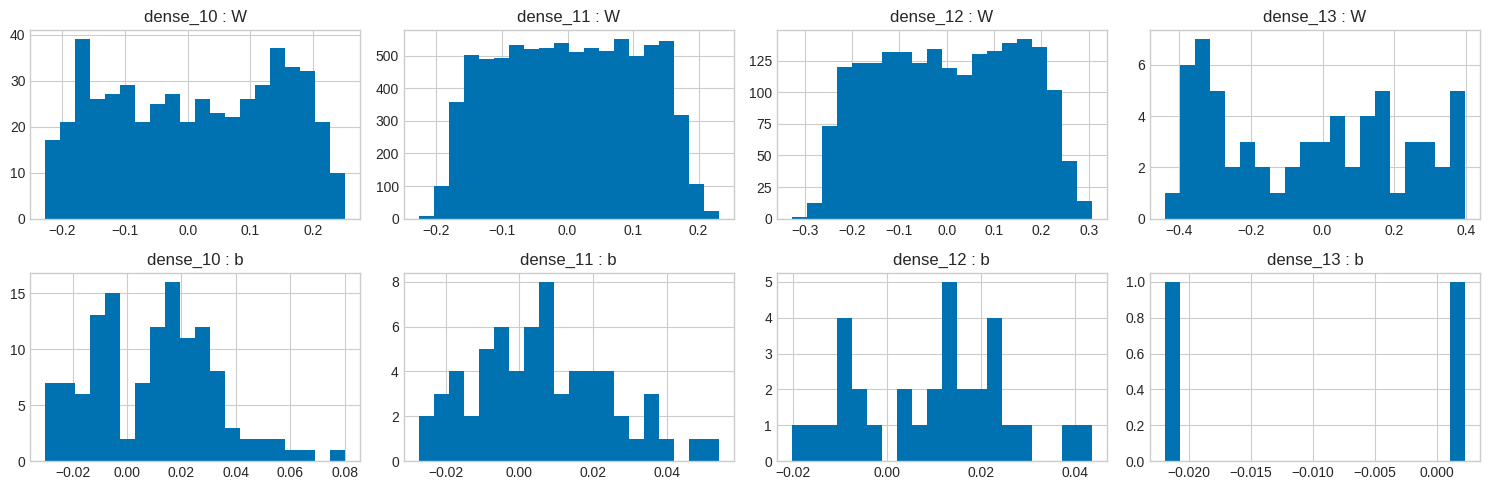

param distribution in model_value


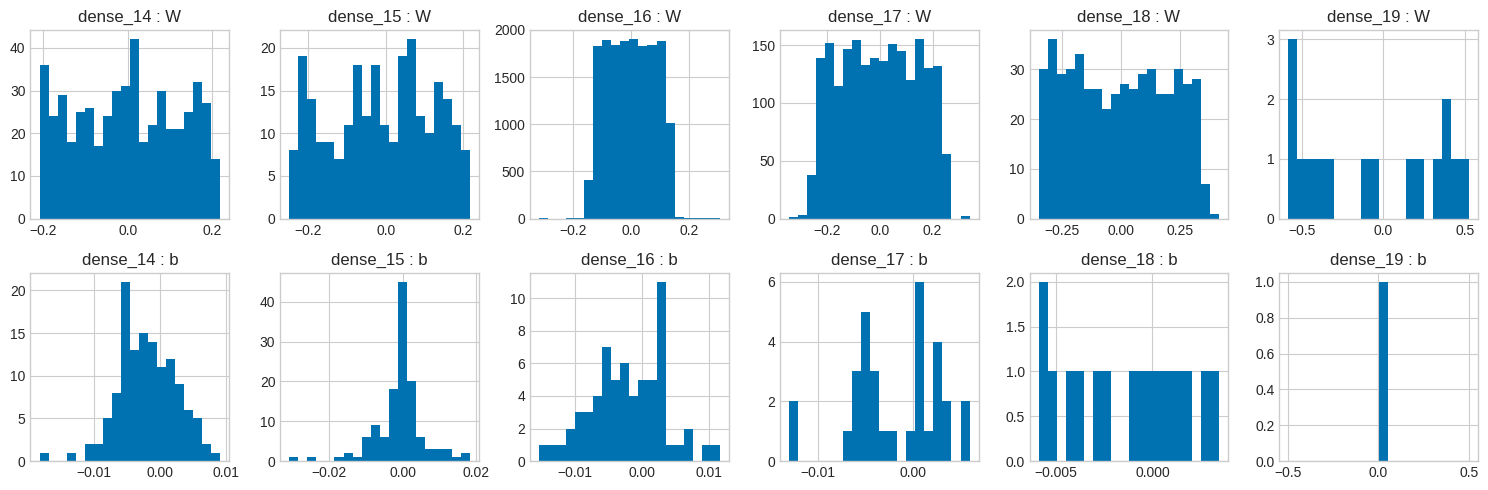

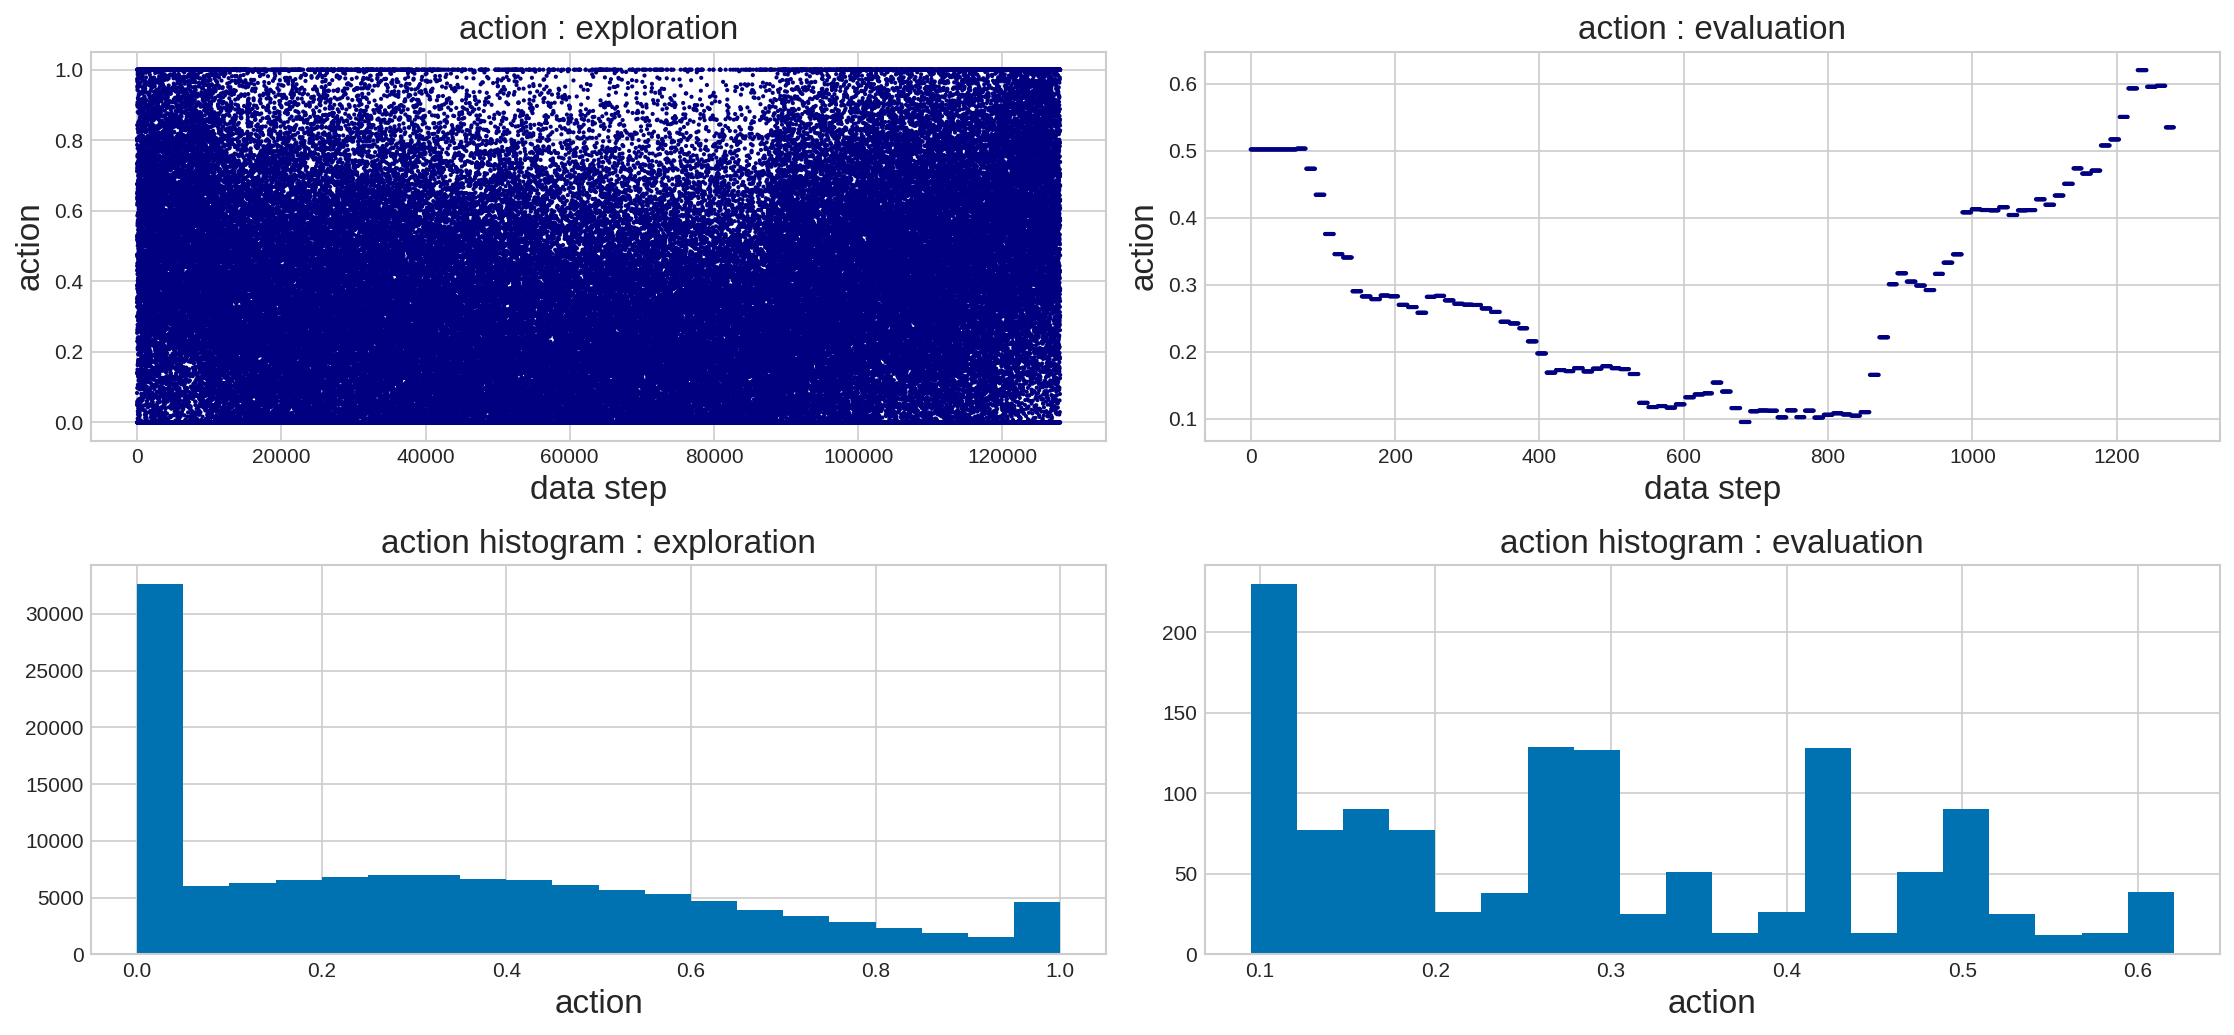

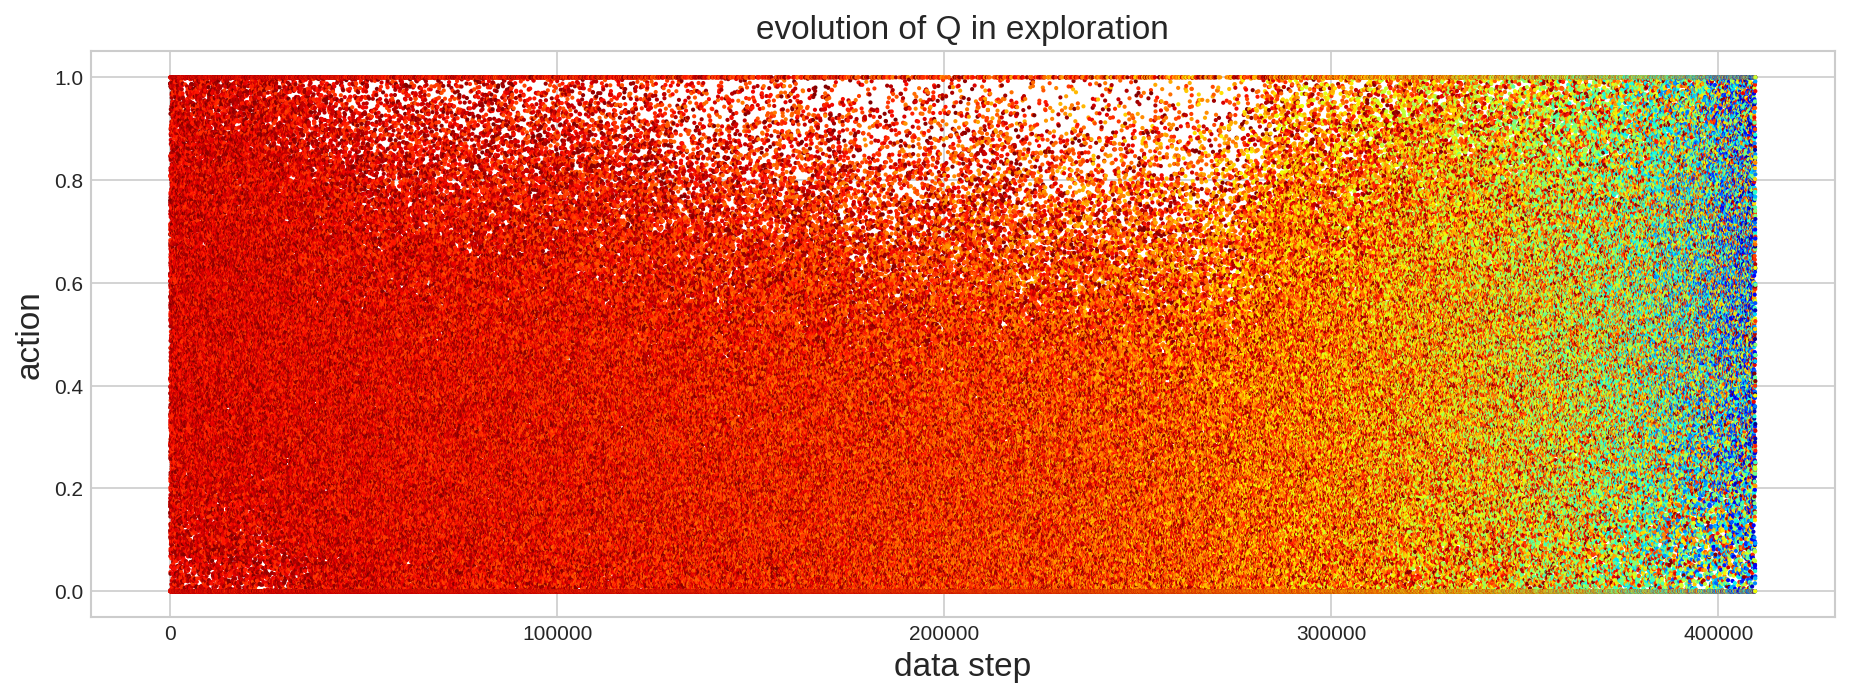

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [8]:
import DDPG  # original DRL code
importlib.reload(DDPG)
from keras import optimizers

env = Env_CAPM.CAPM(returns=returns, sigmas=sigmas, 
                      action_default_mode='continuous')

action_min = 0.0
action_max = 1.0
sigma_max = (action_max - action_min) / 3

model_policy = DDPG.gen_model_policy(state_shapes=env.shapes(), n_actions=env.n_assets, 
                                     hidden_dims=[128, 64, 32], 
                                     reg_l1=0.0, reg_l2=0.0, 
                                     action_min=action_min, action_max=action_max, 
                                     batch_norm_input=False, 
                                     state_reg=False, state_min=0, state_max=10)

model_value = DDPG.gen_model_value(state_shapes=env.shapes(), n_actions=env.n_assets, \
                                   hidden_action_dims=[128,], 
                                   hidden_state_dims=[128,],
                                   hidden_dims=[64, 32, 16],
                                   reg_l1=0.0, reg_l2=0.0,
                                   batch_norm_state_hidden=False)


#df = pd.DataFrame()
for lr_p, lr_v, boltzmann, sigma_end, tau_end in itertools.product(
    [1e-4,], [1e-3,], [False], [1.0,], [1,]):
    print('======================================================')
    print('lr_p={}, lr_v={}, boltzmann={}, sigma_end={}, tau_end={}'
          .format(lr_p, lr_v, boltzmann, sigma_end, tau_end))

    tester = DDPG.Tester(env, model_policy, model_value, name='DDPG_01', 
                         val_min=action_min, val_max=action_max)
    #n_trials = 3
    #n_steps = 10000
    tester.test(n_trials=n_trials,
                gamma=1.0,
                n_steps=n_steps, training_interval=10, n_batches=10, batch_size=256,
                target_update_interval_policy=20, target_update_interval_value=20,
                tau_policy=0.5, tau_value=0.5,
                optimizer_pv=optimizers.Adam(lr=lr_p), optimizer_value=optimizers.Adam(lr=lr_v),
                sigma_start=sigma_max, sigma_end=sigma_max*sigma_end, sigma_interval=n_steps,
                boltzmann=boltzmann, tau_start=10, tau_end=tau_end, tau_interval=n_steps, n_samples=64,
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                wampup_steps=500, 
                get_log=True)

    viz = DDPG.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                               cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(trainer=tester.trainer, 
                      state_valuation=lambda x:np.ravel(x[0][:, 0]), 
                      action_valuation=lambda x:np.ravel(x[:, 0]),
                      data_span_exp=100, data_span_eva=100,)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr_p'] = lr_p
        #df_temp['lr_v'] = lr_v
        #df_temp['boltzmann'] = boltzmann
        #df_temp['sigma_end'] = sigma_end
        #df_temp['tau_end'] = tau_end
        df_temp['Agent'] = 'DDPG' 

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

In [9]:
df.to_csv('01' + '.csv')
pd.options.display.precision = 4
ids = ['Agent']
df[df['t'].max()*0.9<=df['t']].groupby(ids)['return'].describe()

count    mean         std     min     25%     50%     75%     max
Agent                                                                   
A2C     50.0  0.0054  1.3134e-04  0.0050  0.0054  0.0054  0.0054  0.0055
DDPG    50.0  0.0055  4.9341e-06  0.0054  0.0055  0.0055  0.0055  0.0055
DQN     50.0  0.0054  1.4207e-05  0.0054  0.0054  0.0054  0.0055  0.0055

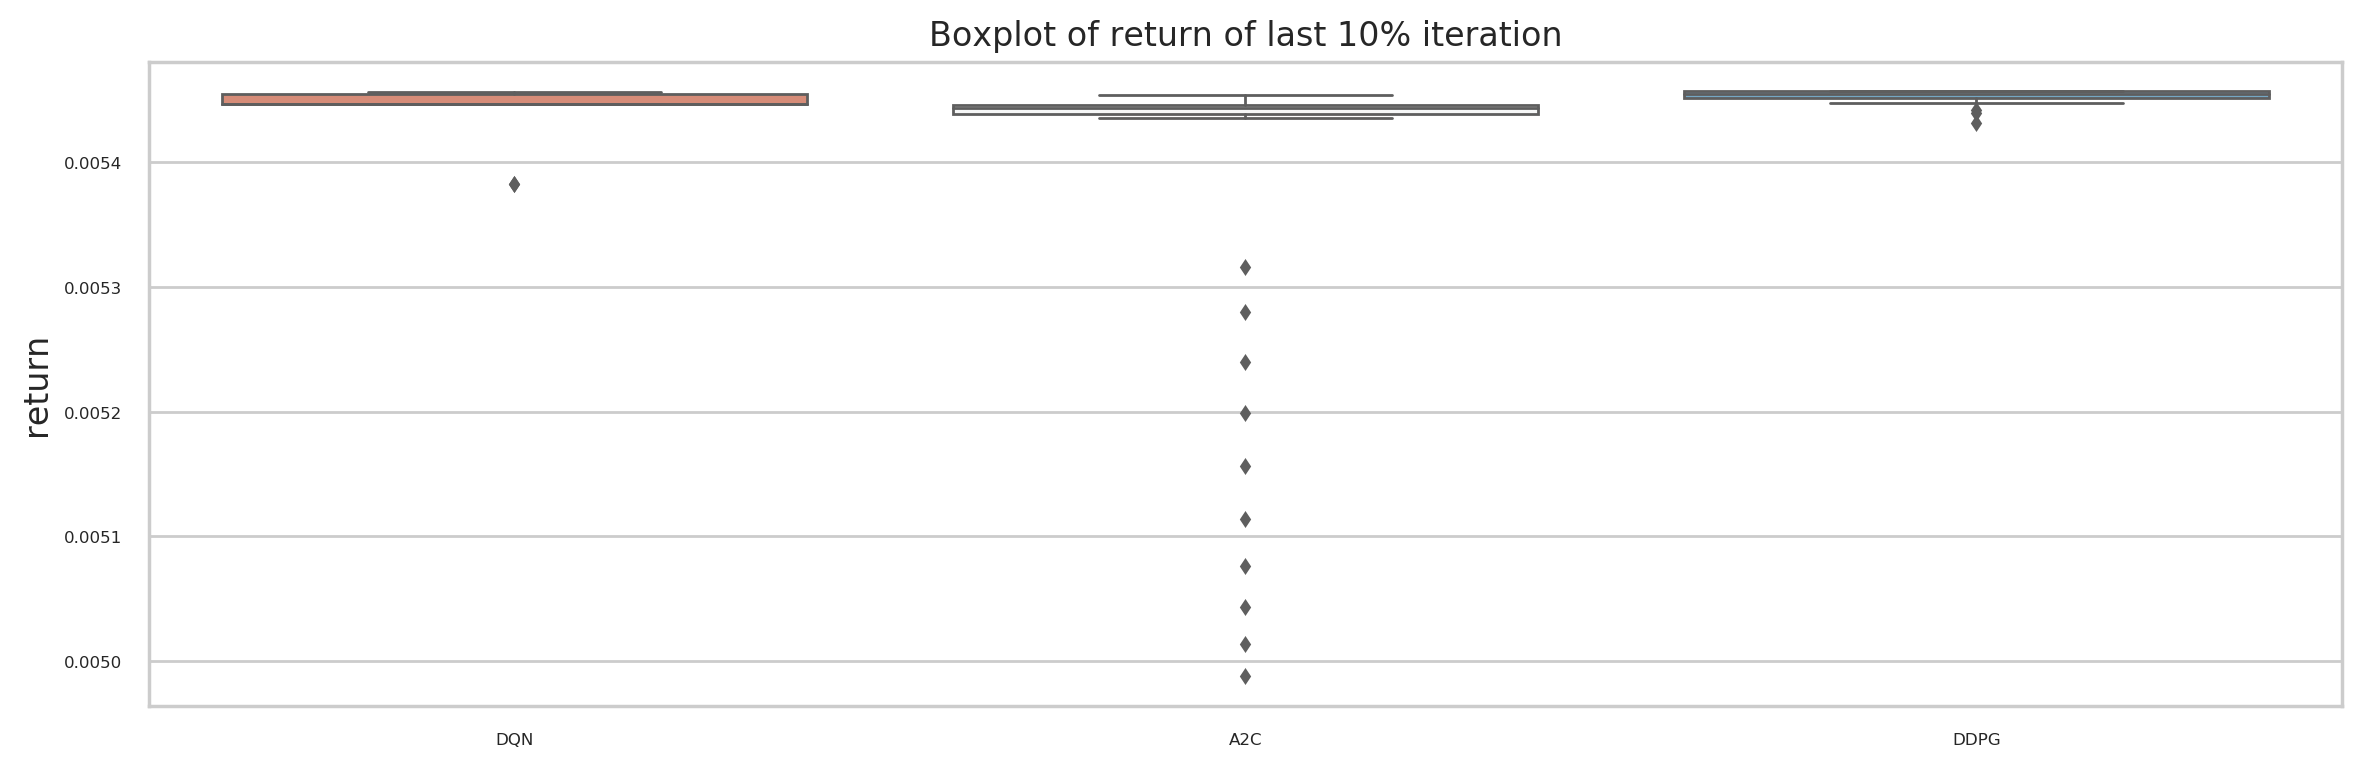

In [10]:
sns.set_style("whitegrid")
sns.set_context("notebook")

#df['ids'] = 'lr='

plt.figure(figsize=(12, 4), dpi=200)

sns.boxplot(data=df[df['t'].max()*0.9<=df['t']], x='Agent', y='return', orient='v', fliersize=3.0, linewidth=1.0, palette='RdBu')

plt.title('Boxplot of return of last 10% iteration', fontsize=12)
plt.xlabel('', fontsize=12)
plt.ylabel('return', fontsize=12)
plt.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


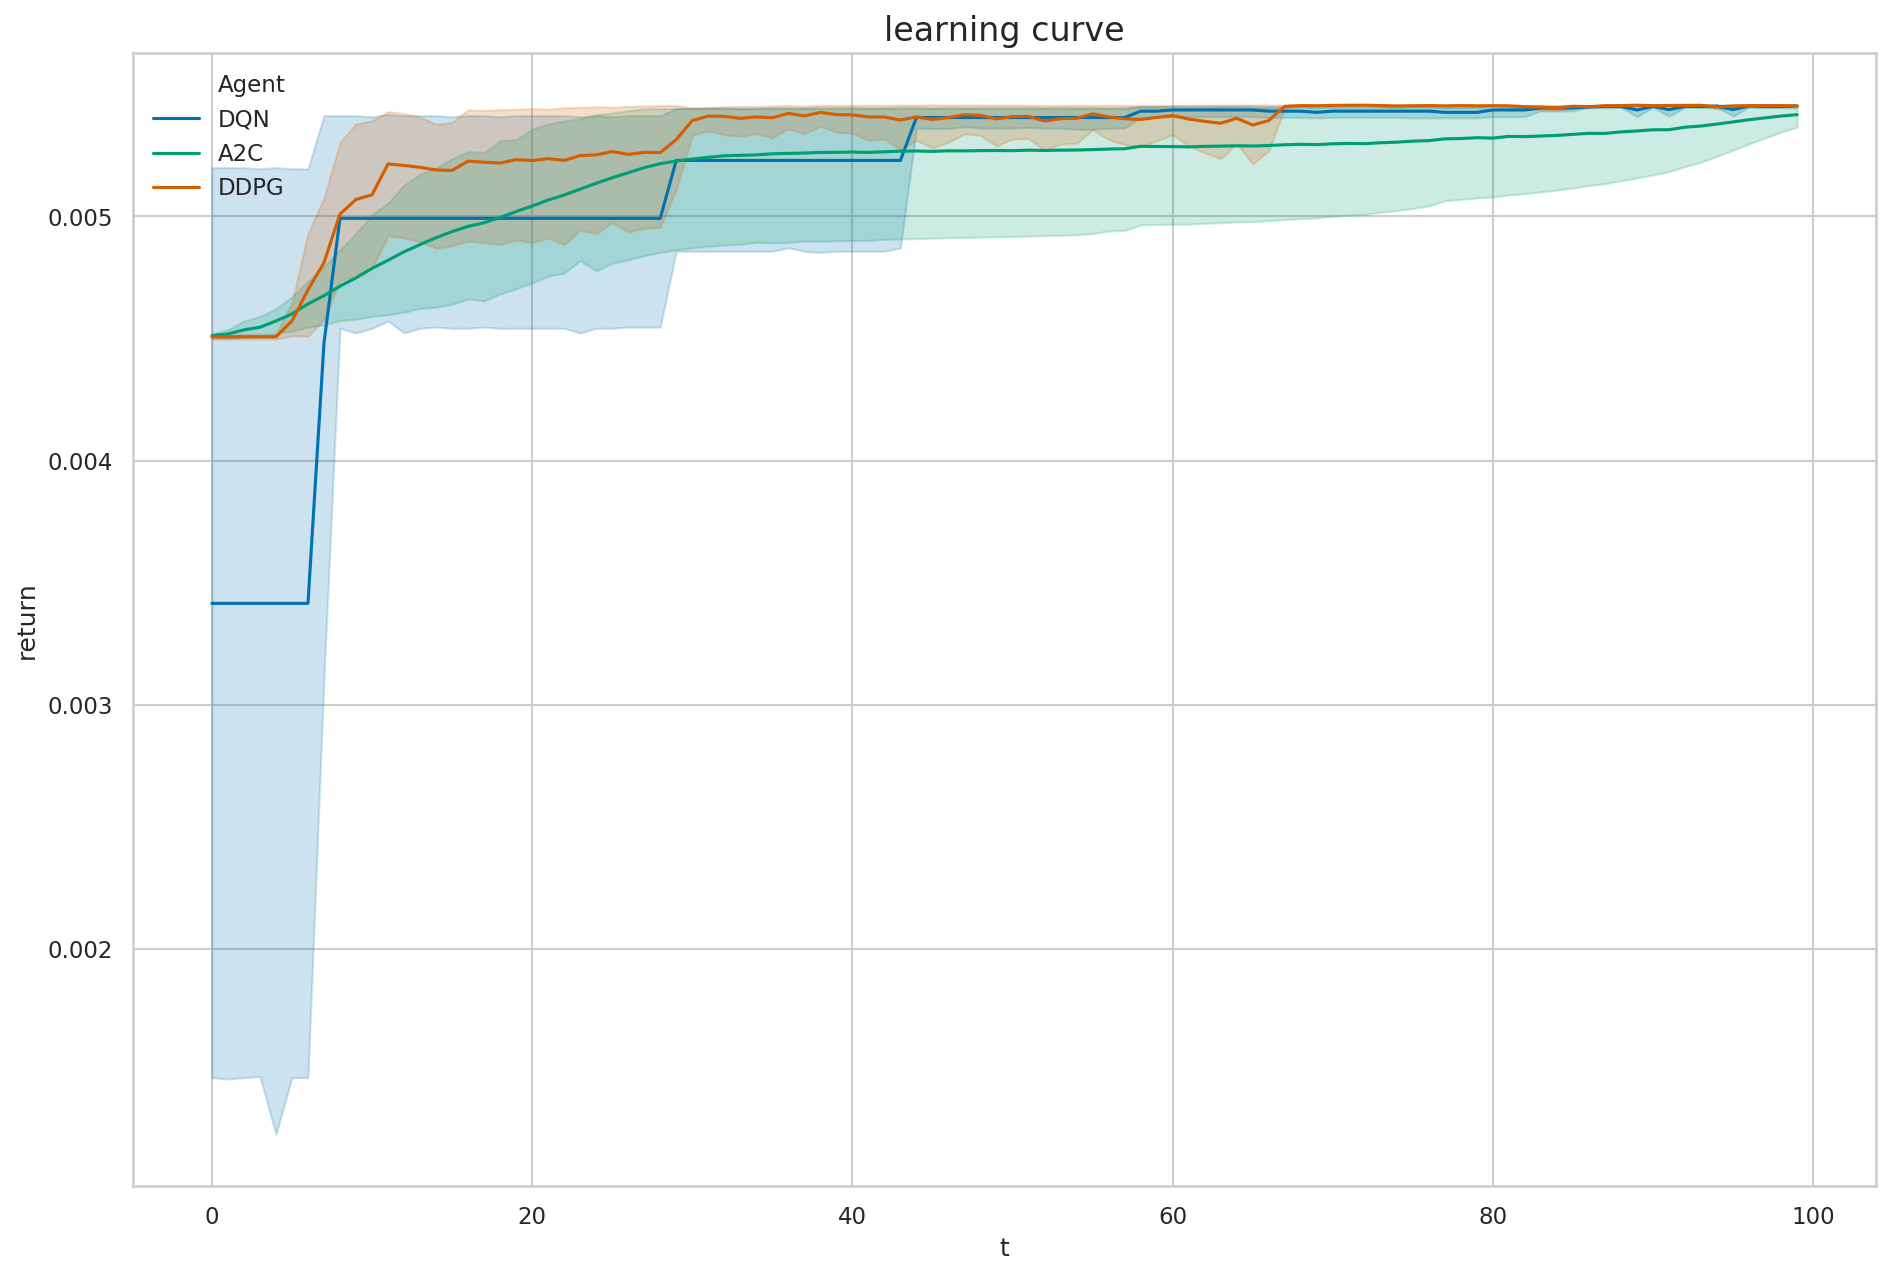

In [11]:
fig = plt.figure(figsize=(15, 10), dpi=150)
sns.lineplot(x='t', y='return', hue='Agent', data=df)
plt.title('learning curve', size=16)
plt.show()

---
## 3. At 5 Assets

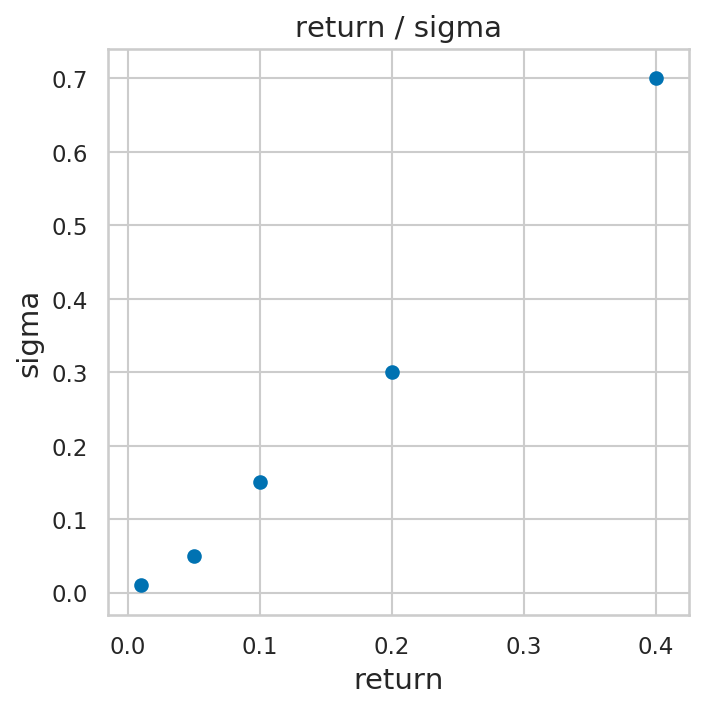

100%|██████████| 1000/1000 [00:00<00:00, 20254.41it/s]


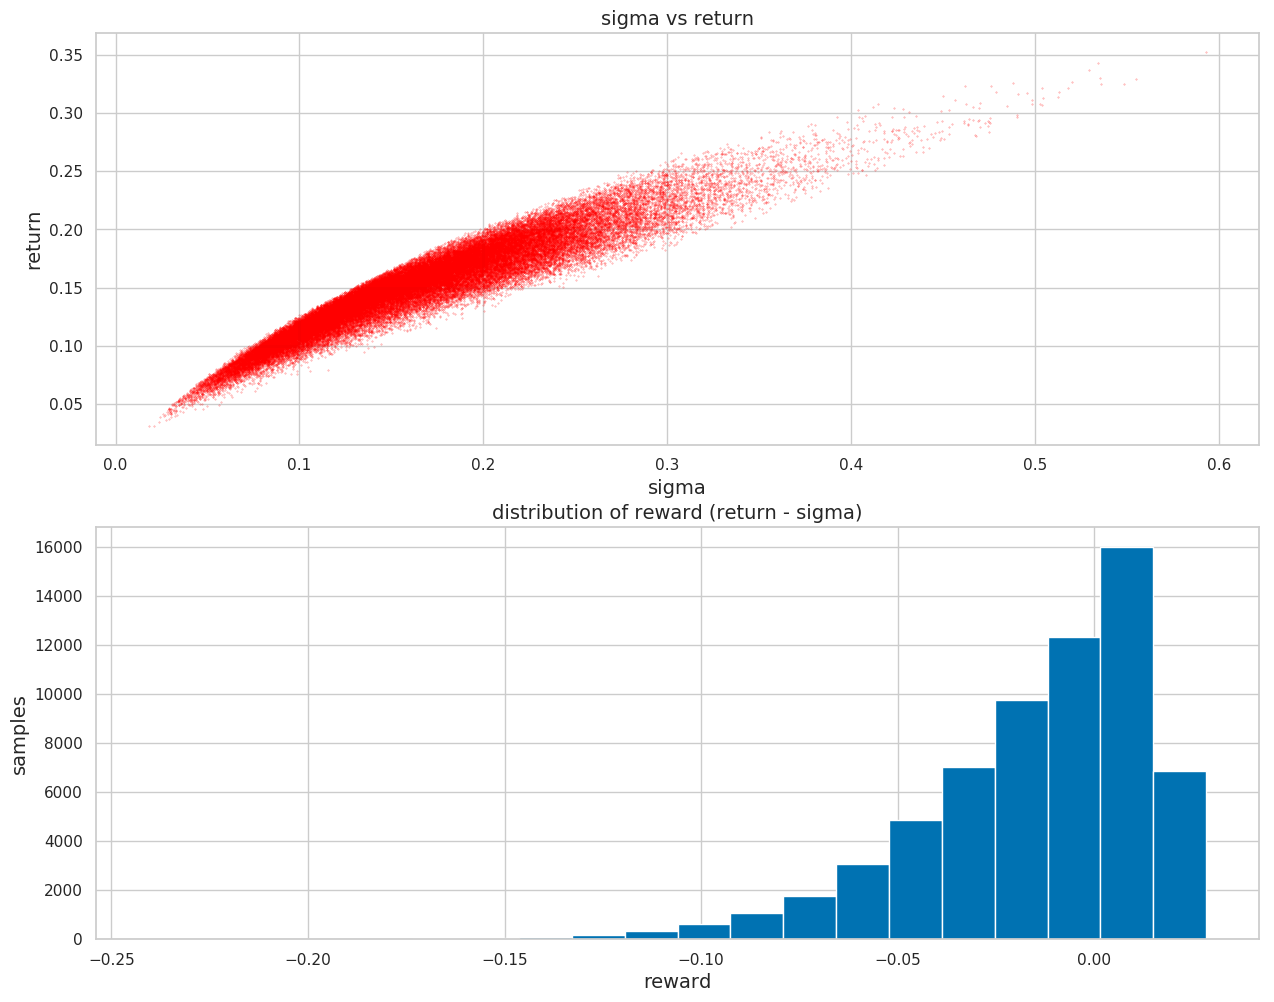

on sample    : maximum reward=0.028473 at action=[0.01  0.797 0.216 0.182 0.06 ], mu=0.096354, sigma=0.067880
on optimizer : maximum reward=0.029220 at action=[2.610e-14 5.890e-01 2.229e-01 1.345e-01 5.362e-02], mu=0.100083, sigma=0.070863


In [12]:
# 5資産の場合
returns = [0.01, 0.05, 0.10, 0.2, 0.4]
sigmas = [0.01, 0.05, 0.15, 0.3, 0.7]

fig = plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(returns, sigmas)
plt.title('return / sigma', fontsize=14)
plt.xlabel('return', fontsize=14)
plt.ylabel('sigma', fontsize=14)
plt.show()

env = Env_CAPM.CAPM(returns=returns, sigmas=sigmas)
env.show_simulation()

In [13]:
n_trials = 3
n_steps = 10000
df = pd.DataFrame()

lr=0.0001, alpha=1.0
start testing... :  2019-10-29 01:03:20.416671
start trial 1/3 trial...


100%|██████████| 10000/10000 [1:09:36<00:00,  2.39it/s]


start trial 2/3 trial...


100%|██████████| 10000/10000 [1:09:46<00:00,  1.52it/s]


start trial 3/3 trial...


100%|██████████| 10000/10000 [1:09:50<00:00,  2.39it/s]


end testing... :  2019-10-29 04:32:38.088160
loss and reward history


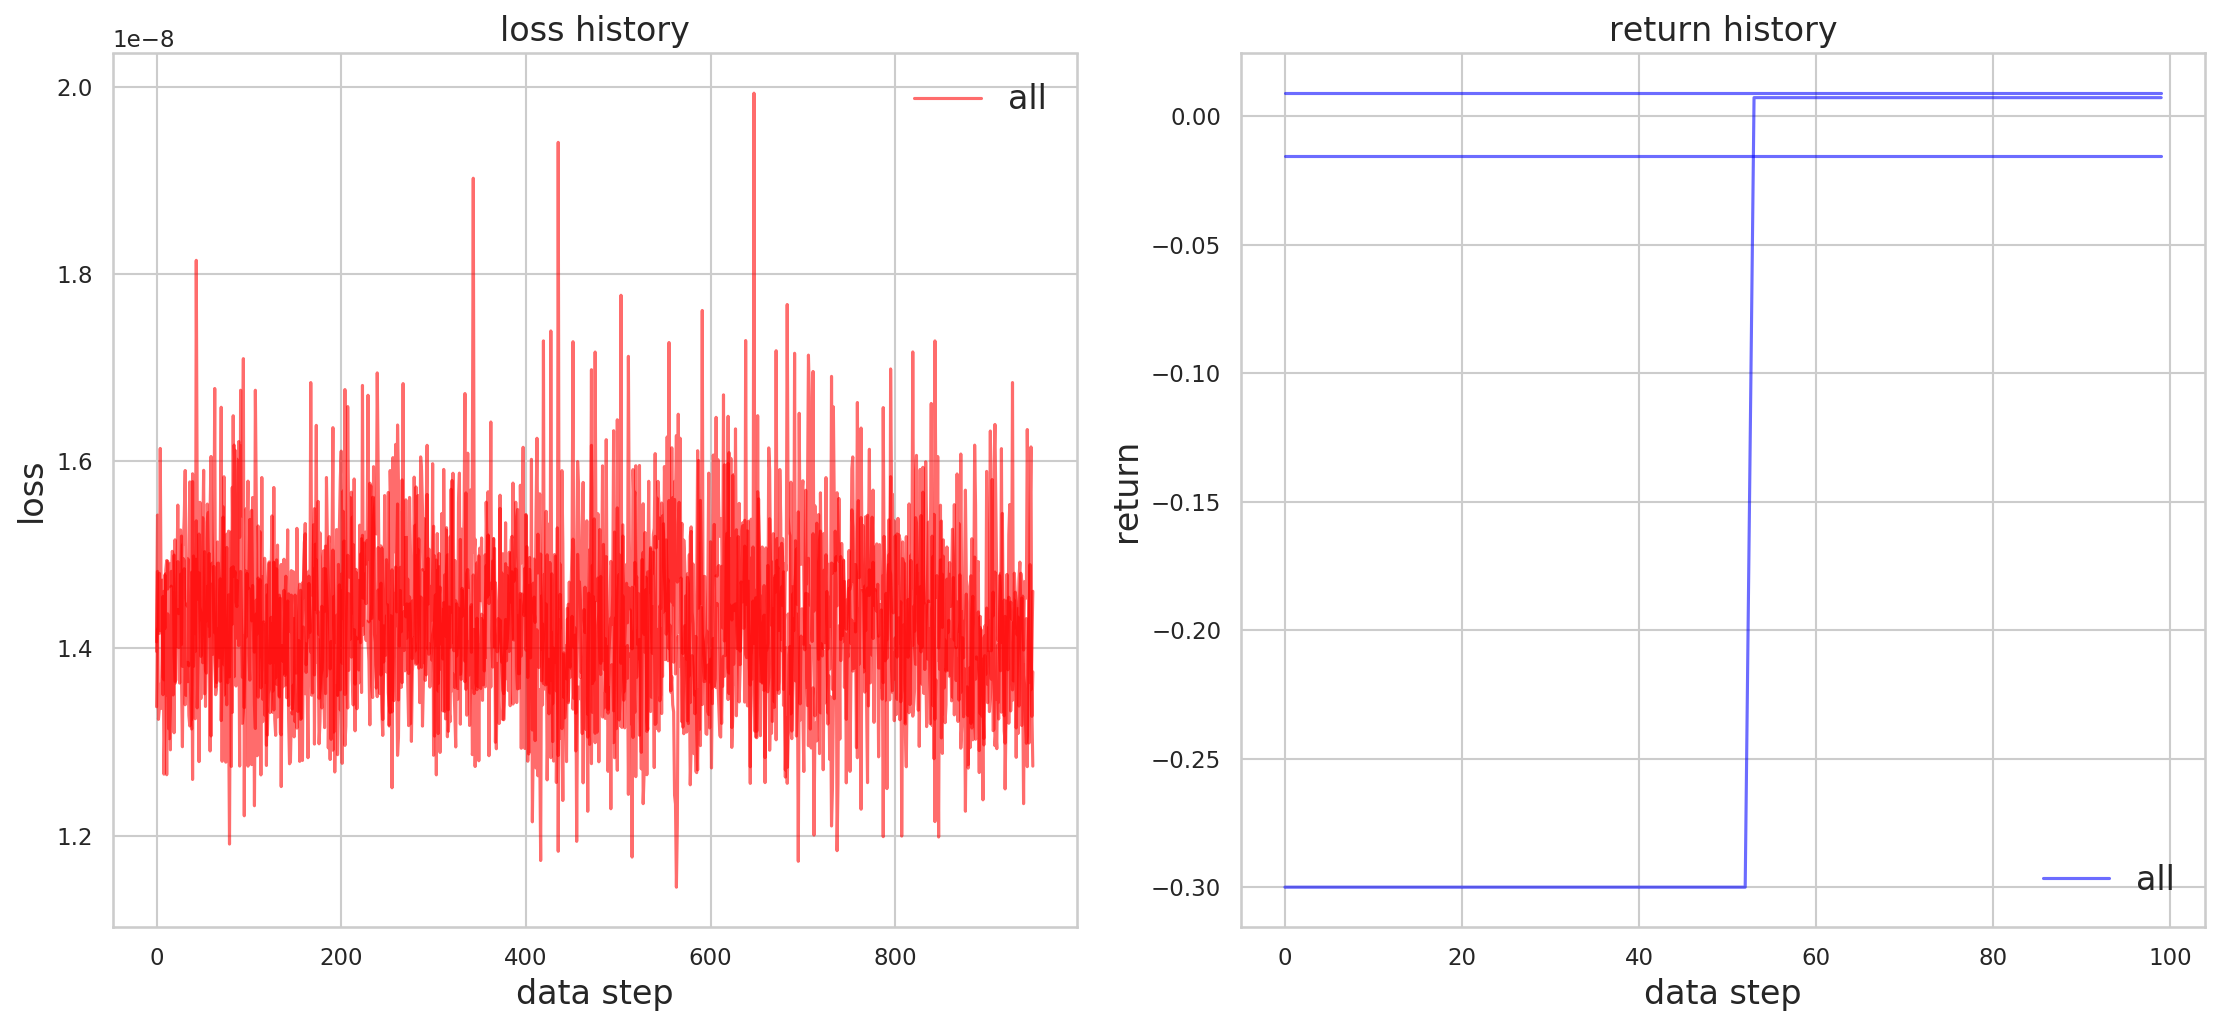

acquired action
action =  [60971 60971 60971 60971 60971 60971 60971 60971 60971 60971]
return [0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007]
param distribution in model


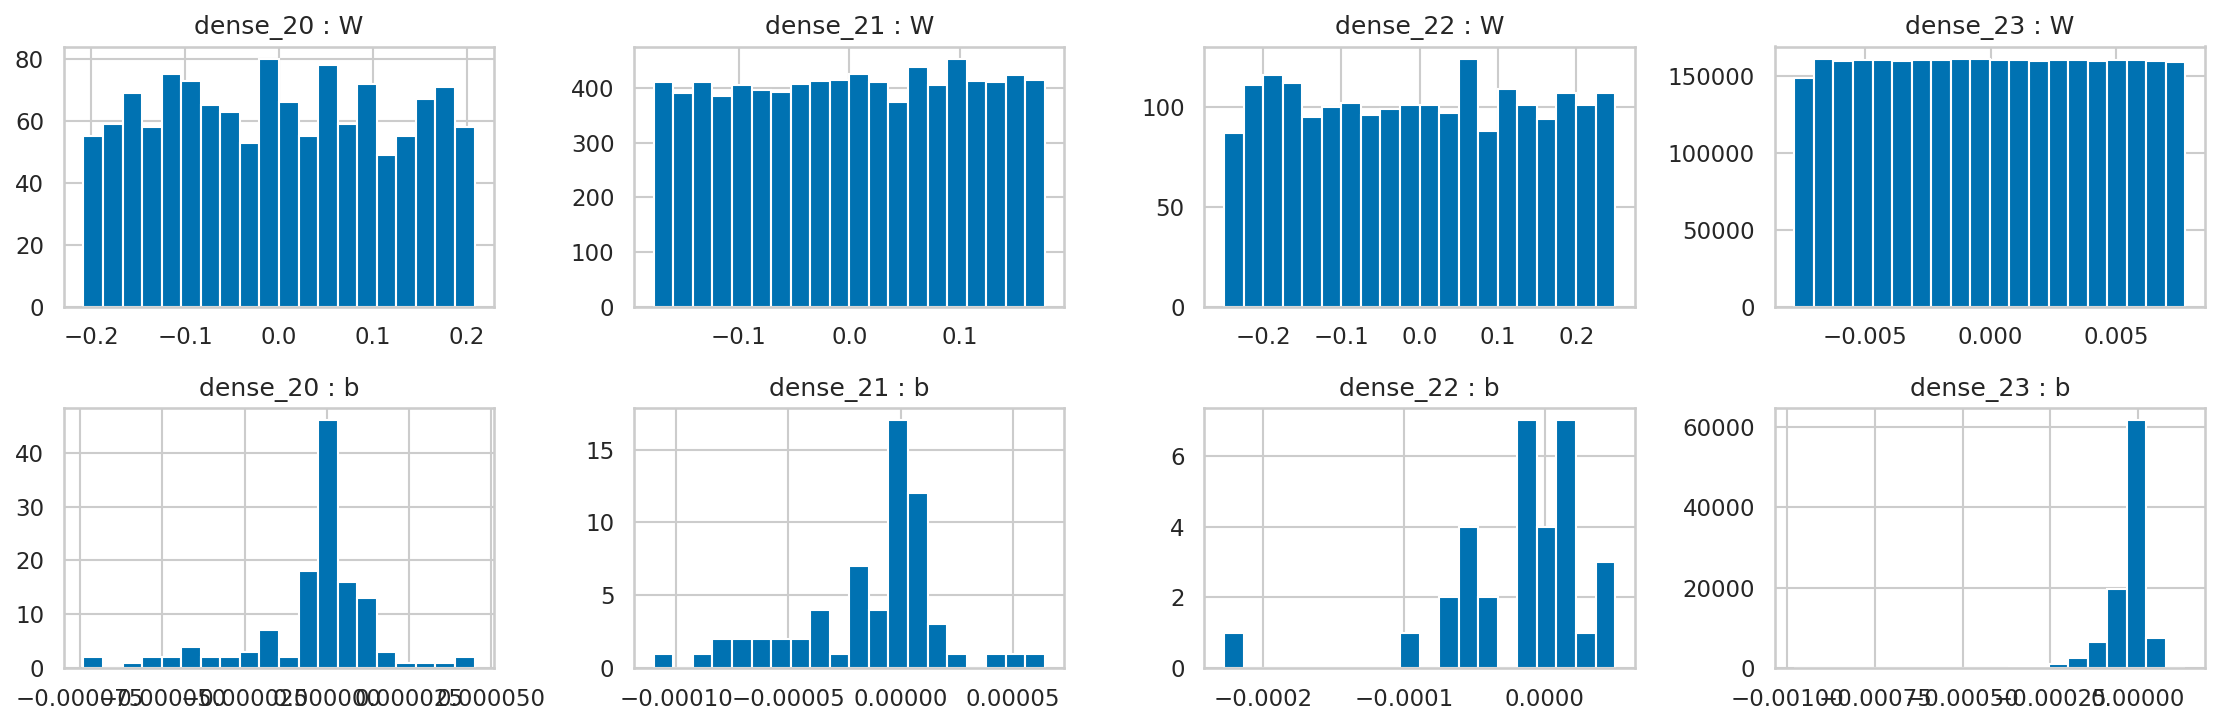

In [14]:
import DQN  # original DRL code
importlib.reload(DQN)
from keras import optimizers

env = Env_CAPM.CAPM(returns=returns, sigmas=sigmas, 
                      action_default_mode='discrete')

model = DQN.gen_model(
    input_shapes=env.shapes(), n_outputs=10 ** env.n_assets, 
    hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0,
    duel=False, duel_value_dim=16, duel_advantage_dim=16
)

#df = pd.DataFrame()
for lr, alpha in itertools.product([1e-4,], [1.0,]):
    print('======================================================')
    print('lr={}, alpha={}'
          .format(lr, alpha))
    
    tester = DQN.Tester(env, model, name='DQN_02')
    #n_trials = 3
    #n_steps = 10000
    tester.test(
        n_trials=n_trials, n_steps=n_steps,
        training_interval=10, n_batches=10, batch_size=256, alpha=alpha, 
        target_update_interval=20, doubleQ=False,
        gamma=1.0, optimizer=optimizers.Adam(lr, clipnorm=10),
        epsilon_start=1.0, epsilon_end=1.0, epsilon_interval=n_steps,
        boltzmann=False, 
        verbose=False, verbose_interval=10, evaluate_interval=100, 
        get_log=False)

    #viz = DQN.Visualizer()
    #viz.viz_action_history(tester.trainer, state_valuation=lambda x:np.ravel(x[0][:, 0]),data_span=100,  
    #                           cmap='jet', alpha=1.0, s=1.0)
    #viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['alpha'] = alpha
        df_temp['Agent'] = 'DQN'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

lr=0.0001, n_advantages=1, mult_critic=0.1, mult_entropy=0.0001
start testing... :  2019-10-29 04:32:39.900874
start 0/3 th trial...


100%|██████████| 10000/10000 [00:54<00:00, 185.13it/s]


start 1/3 th trial...


100%|██████████| 10000/10000 [00:55<00:00, 180.02it/s]


start 2/3 th trial...


100%|██████████| 10000/10000 [00:57<00:00, 182.77it/s]


end testing... :  2019-10-29 04:35:31.981923
loss and reward history


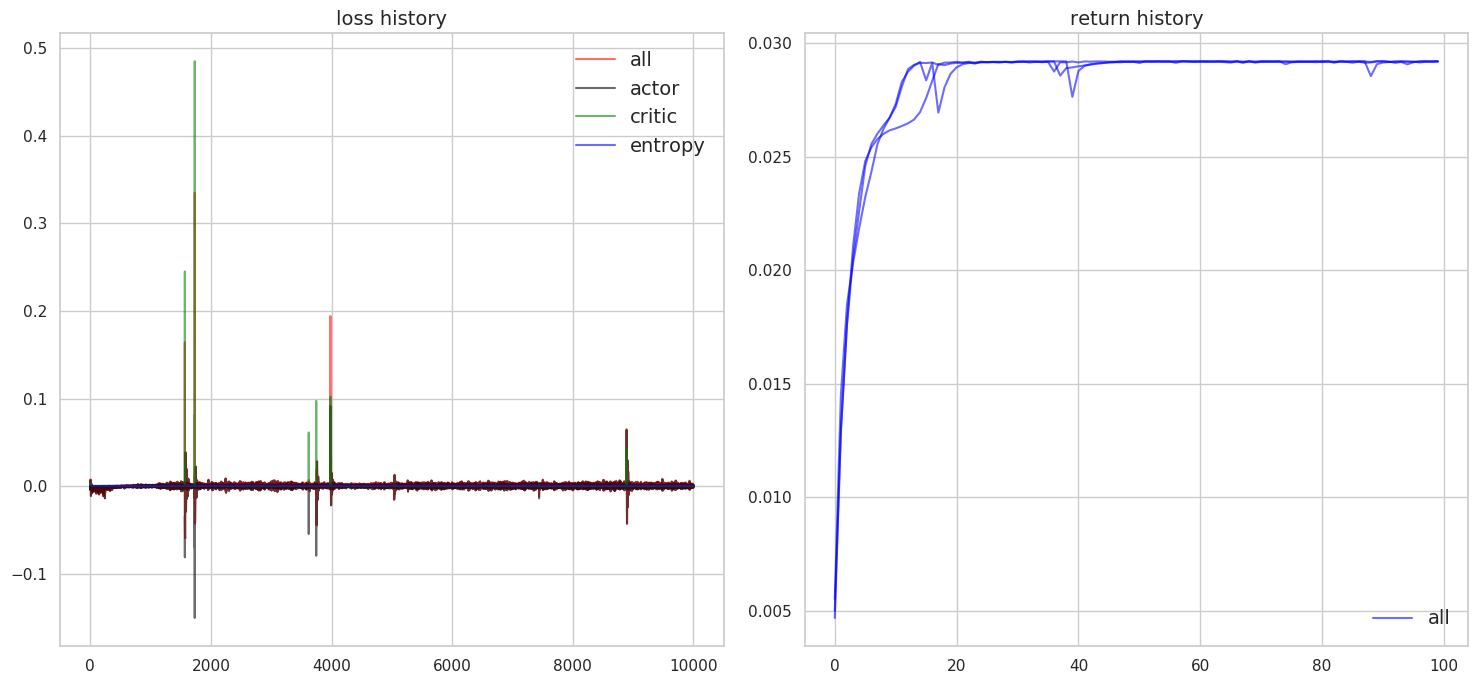

acquired action
action =  [3.949e-05 9.977e-01 3.743e-01 2.261e-01 8.912e-02 3.949e-05 9.977e-01
 3.743e-01 2.261e-01 8.912e-02]
return [0.029 0.029 0.029 0.029 0.029 0.029 0.029 0.029 0.029 0.029]
param distribution in model


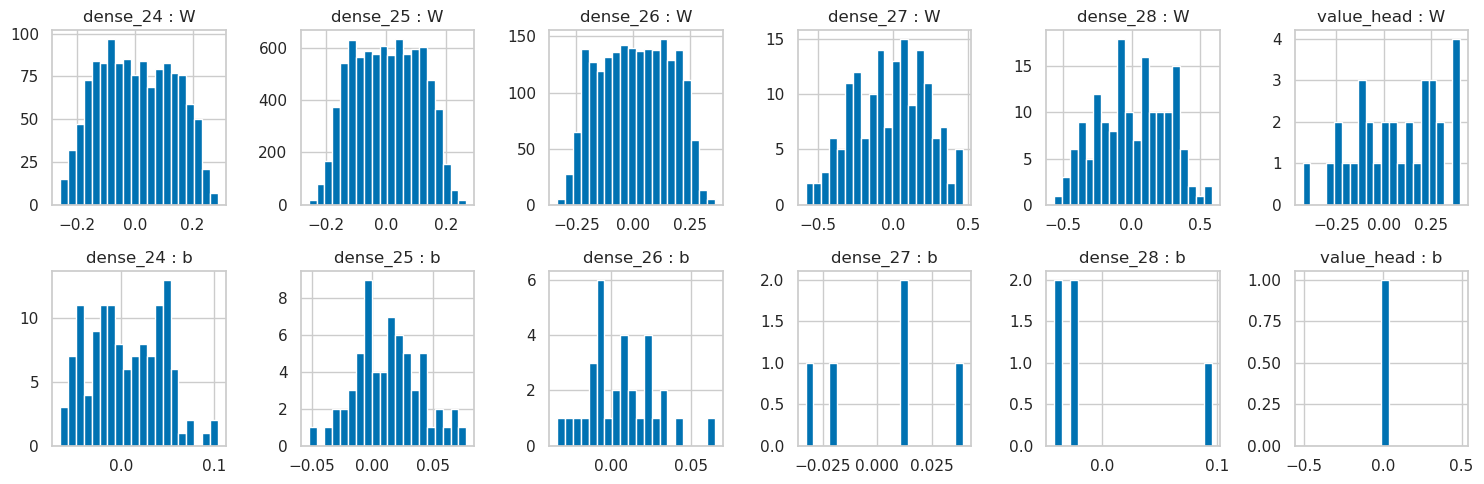

In [15]:
import A2C_continuous  # original DRL code
from keras import optimizers

env = Env_CAPM.CAPM(returns=returns, sigmas=sigmas, 
                    action_default_mode='continuous')

mu_min = 0.0
mu_max = 1.0
sigma_max = (mu_max - mu_min) / 3

model = A2C_continuous.gen_model(input_shapes=env.shapes(), n_outputs=env.n_assets, \
                                 hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, \
                                mu_min=mu_min, mu_max=mu_max, 
                                va_min=(0.00001)**2, va_max=sigma_max**2, 
                                input_reg=False, input_min=0, input_max=1)

#df = pd.DataFrame()
for lr, n_advantages, mult_critic, mult_entropy in itertools.product(
    [1e-4,], [1,], [0.1,], [0.0001,]):
    print('======================================================')
    print('lr={}, n_advantages={}, mult_critic={}, mult_entropy={}'
          .format(lr, n_advantages, mult_critic, mult_entropy))

    tester = A2C_continuous.Tester(env, model, name='A2C_02',
                                   val_min=mu_min-3*sigma_max, val_max=mu_max+3*sigma_max)
    #n_trials = 3
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps, n_advantages=n_advantages,
               gamma=1.0, optimizer=optimizers.Adam(lr=lr),
               mult_actor=1.0, mult_critic=mult_critic, mult_entropy=mult_entropy,
               verbose=False, verbose_interval=100, evaluate_interval=100, 
               get_log=False)

    #viz = A2C_continuous.Visualizer()
    #viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
    #                       cmap='jet', alpha=1.0, s=1.0)

    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['n_advantages'] = n_advantages
        #df_temp['mult_critic'] = mult_critic
        #df_temp['mult_entropy'] = mult_entropy
        df_temp['Agent'] = 'A2C'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

lr_p=0.0001, lr_v=0.001, boltzmann=False, sigma_end=1.0, tau_end=1
start testing... :  2019-10-29 04:35:37.632200
start 0/3 th trial...


100%|██████████| 10000/10000 [02:46<00:00, 59.60it/s]


start 1/3 th trial...


100%|██████████| 10000/10000 [02:52<00:00, 57.19it/s]


start 2/3 th trial...


100%|██████████| 10000/10000 [03:00<00:00, 54.90it/s]


end testing... :  2019-10-29 04:44:33.840208
loss and reward history


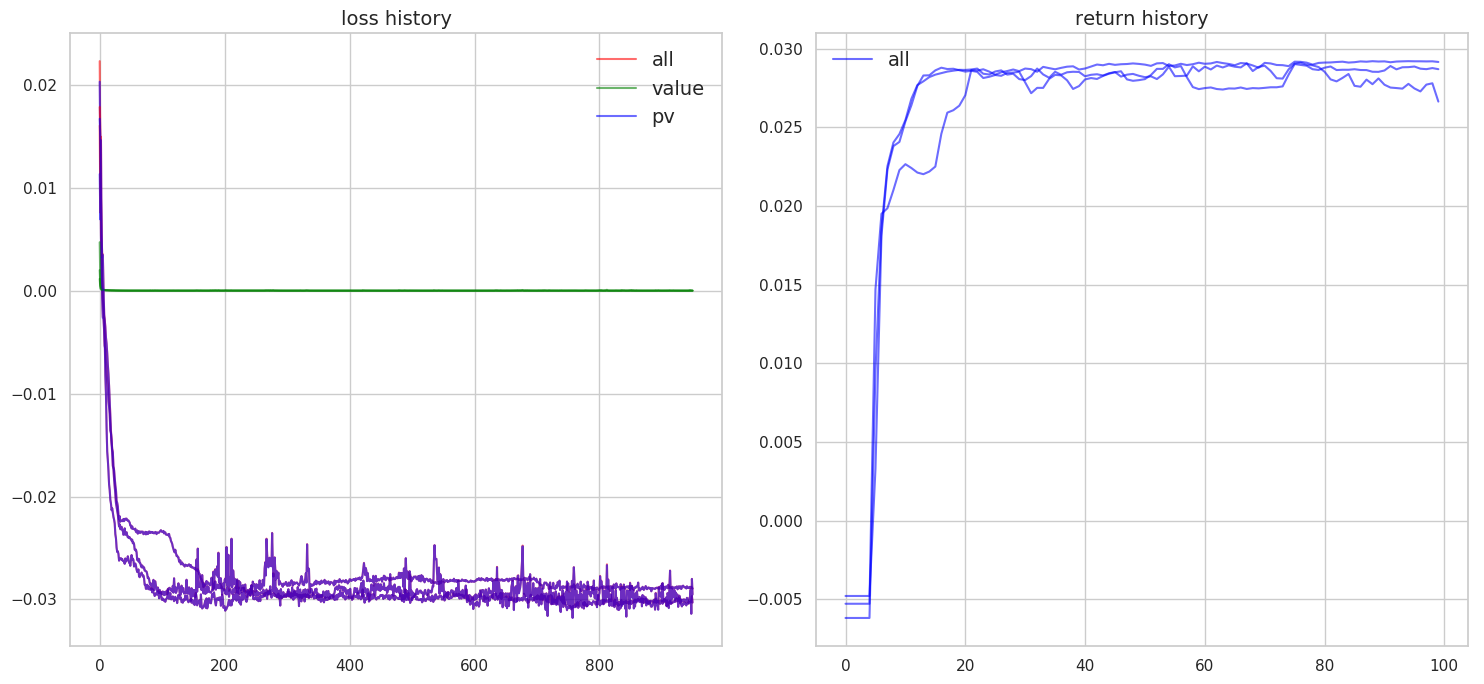

acquired action
action =  [8.088e-05 4.205e-01 3.144e-01 1.827e-01 4.783e-02 8.088e-05 4.205e-01
 3.144e-01 1.827e-01 4.783e-02]
return [0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027]
param distribution in model_policy


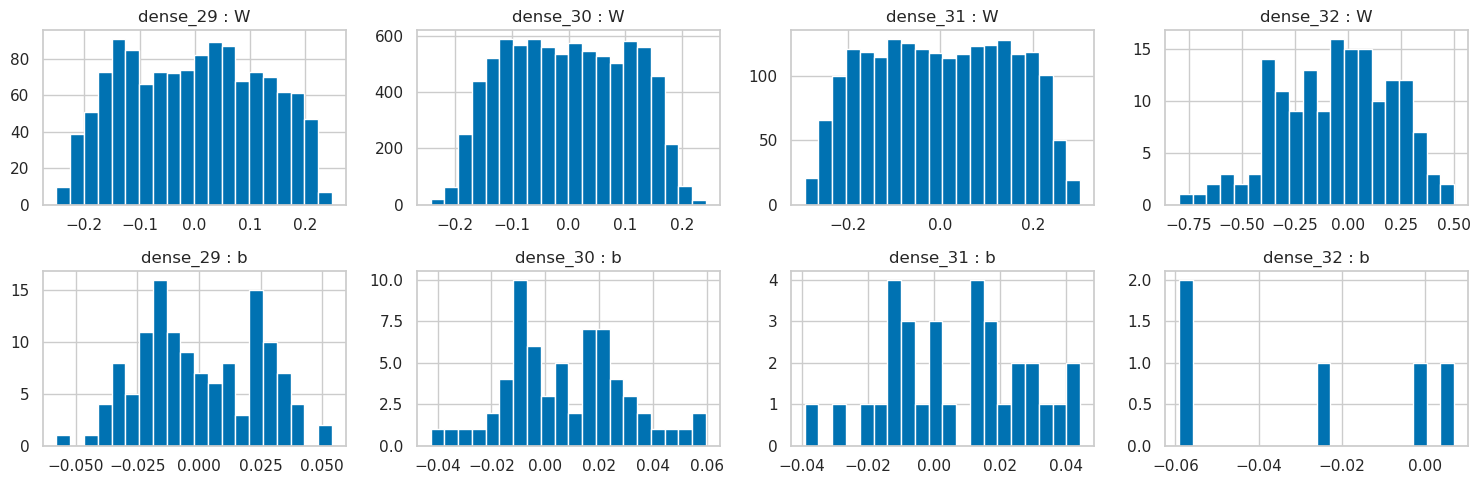

param distribution in model_value


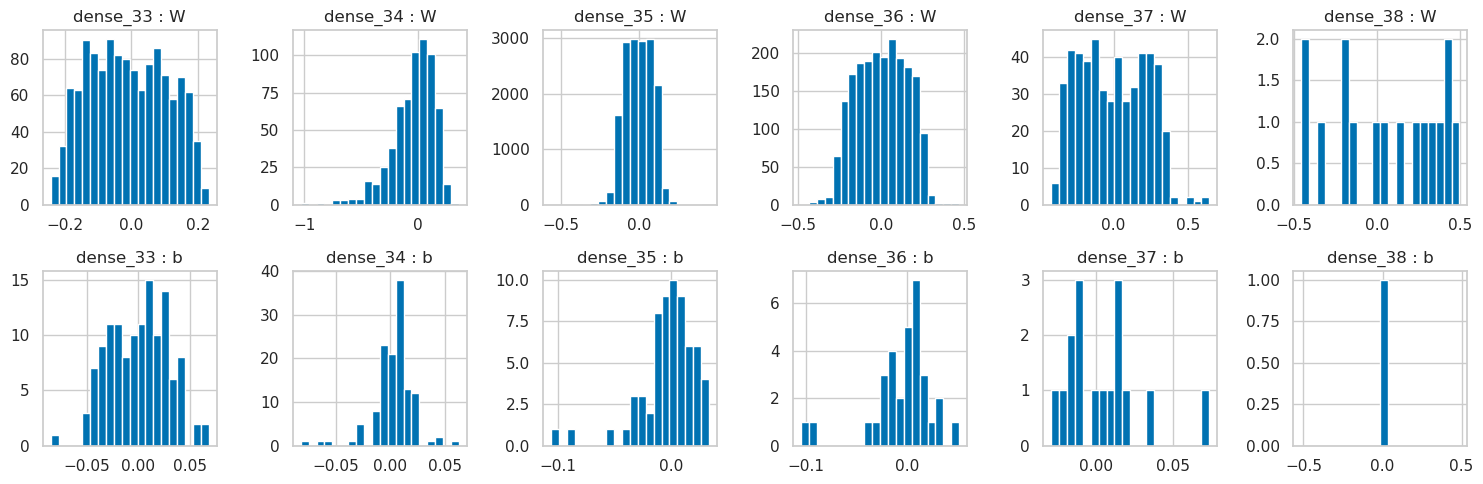

In [16]:
import DDPG  # original DRL code
importlib.reload(DDPG)
from keras import optimizers

env = Env_CAPM.CAPM(returns=returns, sigmas=sigmas, 
                      action_default_mode='continuous')

action_min = 0.0
action_max = 1.0
sigma_max = (action_max - action_min) / 3

model_policy = DDPG.gen_model_policy(state_shapes=env.shapes(), n_actions=env.n_assets, 
                                     hidden_dims=[128, 64, 32], 
                                     reg_l1=0.0, reg_l2=0.0, 
                                     action_min=action_min, action_max=action_max, 
                                     batch_norm_input=False, 
                                     state_reg=False, state_min=0, state_max=10)

model_value = DDPG.gen_model_value(state_shapes=env.shapes(), n_actions=env.n_assets, \
                                   hidden_action_dims=[128,], 
                                   hidden_state_dims=[128,],
                                   hidden_dims=[64, 32, 16],
                                   reg_l1=0.0, reg_l2=0.0,
                                   batch_norm_state_hidden=False)


#df = pd.DataFrame()
for lr_p, lr_v, boltzmann, sigma_end, tau_end in itertools.product(
    [1e-4,], [1e-3,], [False], [1.0,], [1,]):
    print('======================================================')
    print('lr_p={}, lr_v={}, boltzmann={}, sigma_end={}, tau_end={}'
          .format(lr_p, lr_v, boltzmann, sigma_end, tau_end))

    tester = DDPG.Tester(env, model_policy, model_value, name='DDPG_02', 
                         val_min=action_min, val_max=action_max)
    #n_trials = 3
    #n_steps = 10000
    tester.test(n_trials=n_trials,
                gamma=1.0,
                n_steps=n_steps, training_interval=10, n_batches=10, batch_size=256,
                target_update_interval_policy=20, target_update_interval_value=20,
                tau_policy=0.5, tau_value=0.5,
                optimizer_pv=optimizers.Adam(lr=lr_p), optimizer_value=optimizers.Adam(lr=lr_v),
                sigma_start=sigma_max, sigma_end=sigma_max*sigma_end, sigma_interval=n_steps,
                boltzmann=boltzmann, tau_start=10, tau_end=tau_end, tau_interval=n_steps, n_samples=64,
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                wampup_steps=500, 
                get_log=False)

    #viz = DDPG.Visualizer()
    #viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
    #                           cmap='jet', alpha=1.0, s=1.0)
    #viz.viz_Q_history(trainer=tester.trainer, 
    #                  state_valuation=lambda x:np.ravel(x[0][:, 0]), 
    #                  action_valuation=lambda x:np.ravel(x[:, 0]),
    #                  data_span_exp=100, data_span_eva=100,)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr_p'] = lr_p
        #df_temp['lr_v'] = lr_v
        #df_temp['boltzmann'] = boltzmann
        #df_temp['sigma_end'] = sigma_end
        #df_temp['tau_end'] = tau_end
        df_temp['Agent'] = 'DDPG' 

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

In [17]:
df.to_csv('02' + '.csv')
pd.options.display.precision = 4
ids = ['Agent']
df[df['t'].max()*0.9<=df['t']].groupby(ids)['return'].describe()

count    mean         std     min     25%     50%     75%     max
Agent                                                                   
A2C     30.0  0.0292  2.8219e-05  0.0291  0.0292  0.0292  0.0292  0.0292
DDPG    30.0  0.0285  7.5999e-04  0.0266  0.0277  0.0288  0.0292  0.0292
DQN     30.0  0.0003  1.1297e-02 -0.0154 -0.0154  0.0072  0.0090  0.0090

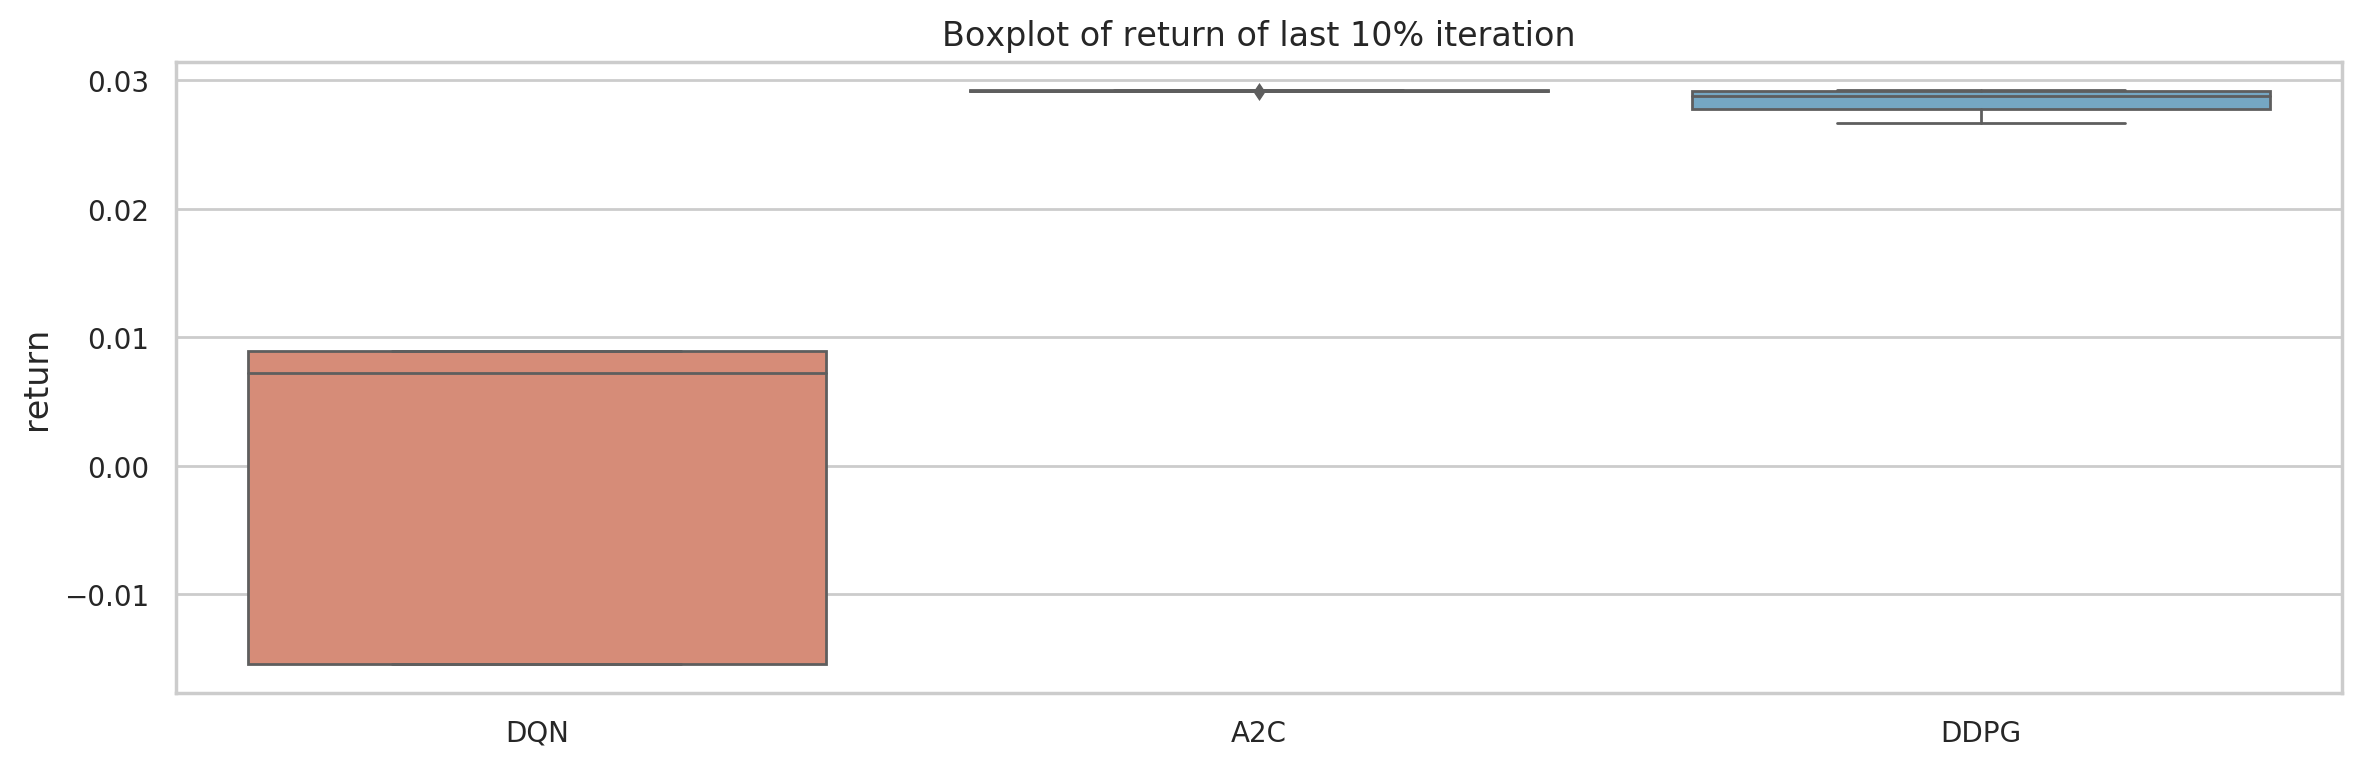

In [18]:
sns.set_style("whitegrid")
sns.set_context("notebook")

plt.figure(figsize=(12, 4), dpi=200)

sns.boxplot(data=df[df['t'].max()*0.9<=df['t']], x='Agent', y='return', orient='v', fliersize=3.0, linewidth=1.0, palette='RdBu')

plt.title('Boxplot of return of last 10% iteration', fontsize=12)
plt.xlabel('', fontsize=12)
plt.ylabel('return', fontsize=12)
plt.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


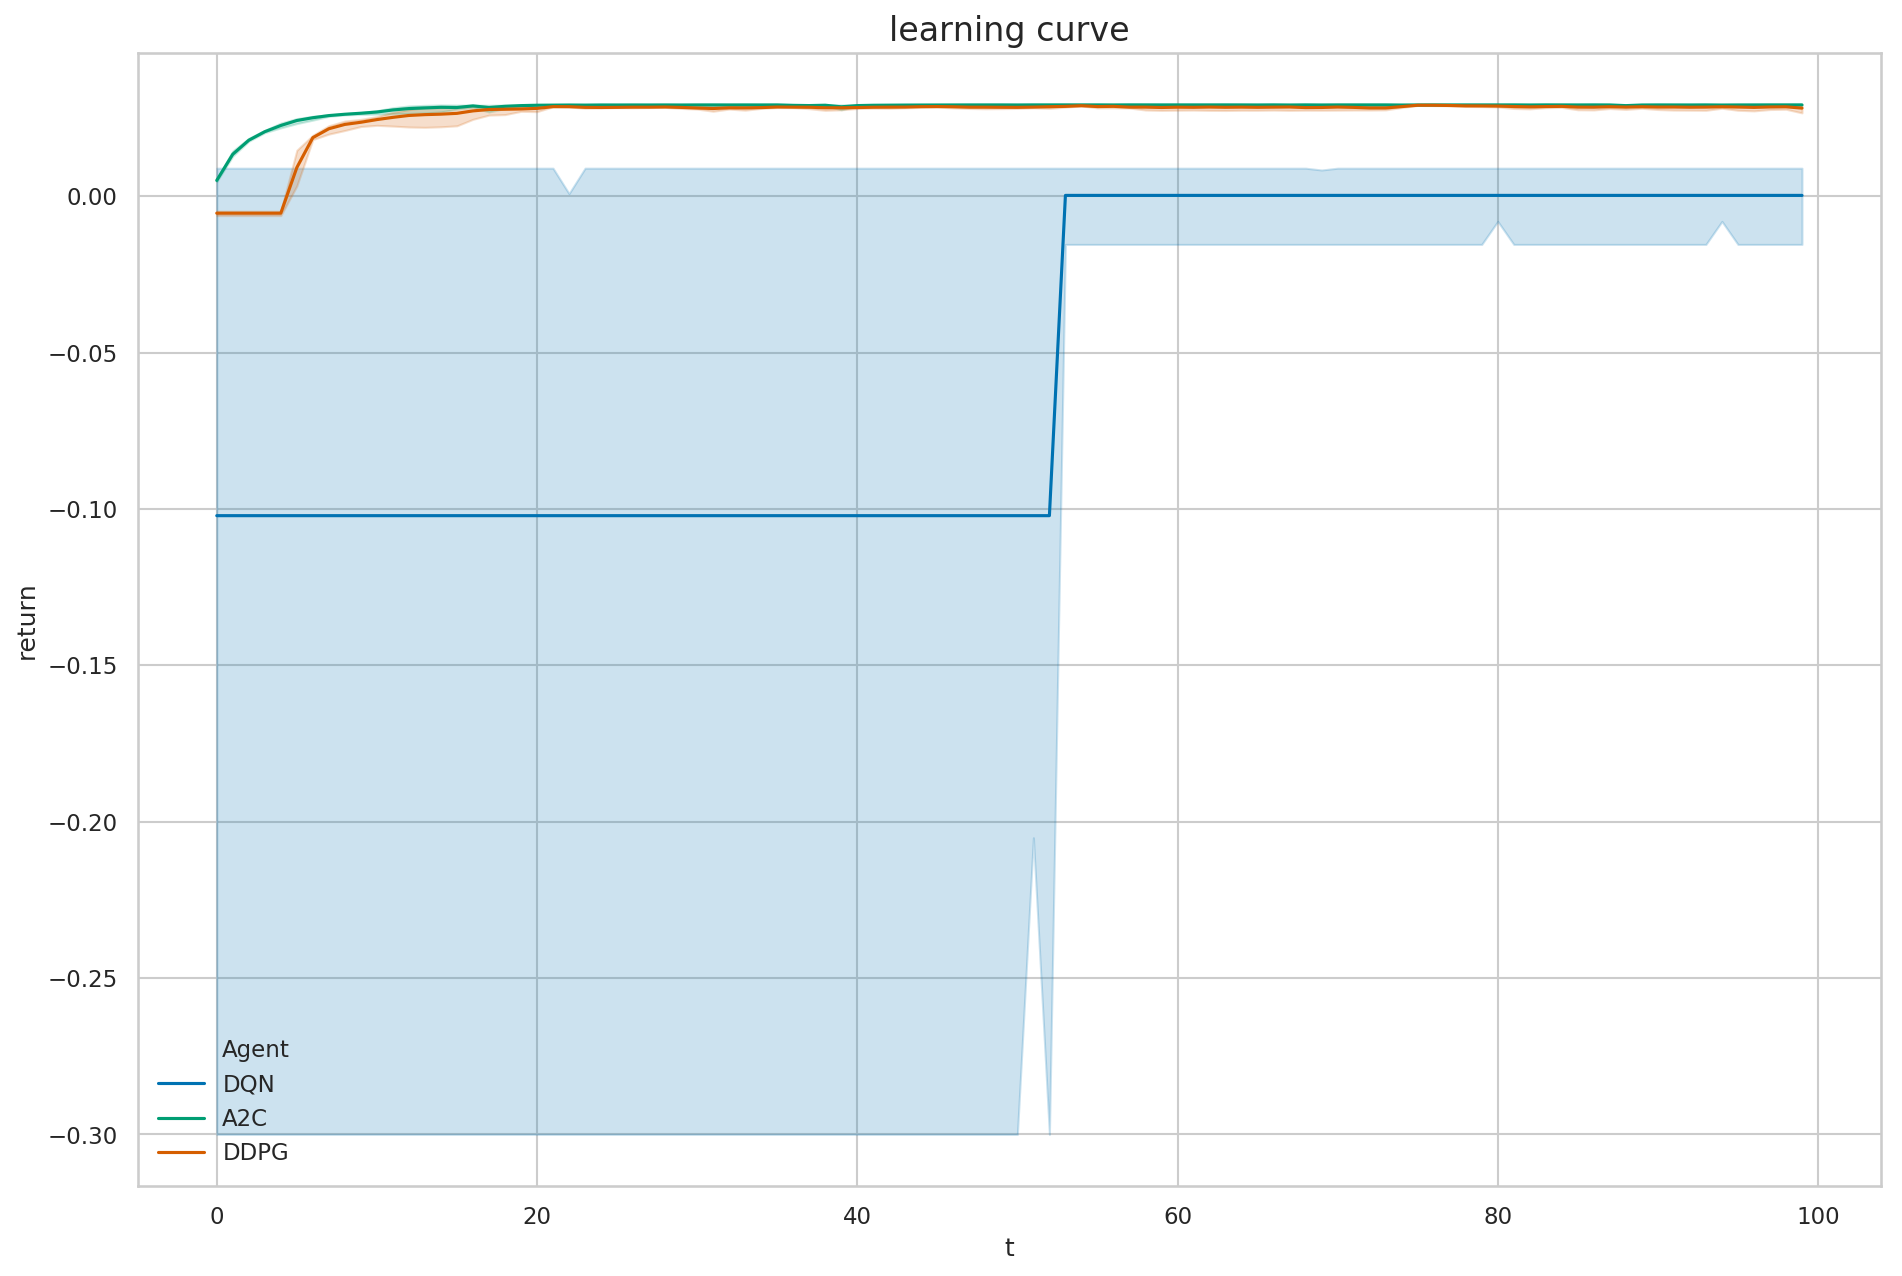

In [19]:
fig = plt.figure(figsize=(15, 10), dpi=150)
sns.lineplot(x='t', y='return', hue='Agent', data=df)
plt.title('learning curve', size=16)
plt.show()

---
## 4. 一般拡張可能性の検証
ここまでは，固定した環境（利率・分散）で最適解を探せるかどうかという問題を扱ってきた．ここからは，利率・分散がランダムに変動するケースを学習させることで，新たな状態でも正しい答えが出せるようになるかどうかを検証する．

In [20]:
env_gen = Env_CAPM.CAPM(returns=np.zeros(shape=(2)), sigmas=np.zeros(shape=(2)), gen_automatic=True)
returns = np.zeros(shape=(2))
sigmas = np.zeros(shape=(2))

In [21]:
n_trials = 5
n_steps = 10000
df = pd.DataFrame()
testers = {}

lr=0.0001, alpha=1.0
start testing... :  2019-10-29 04:44:40.770737
start trial 1/5 trial...


100%|██████████| 10000/10000 [02:50<00:00, 55.38it/s]


start trial 2/5 trial...


100%|██████████| 10000/10000 [02:53<00:00, 57.03it/s]


start trial 3/5 trial...


100%|██████████| 10000/10000 [02:57<00:00, 56.07it/s]


start trial 4/5 trial...


100%|██████████| 10000/10000 [02:57<00:00, 55.62it/s]


start trial 5/5 trial...


100%|██████████| 10000/10000 [03:00<00:00, 54.45it/s]


end testing... :  2019-10-29 04:59:30.414670
loss and reward history


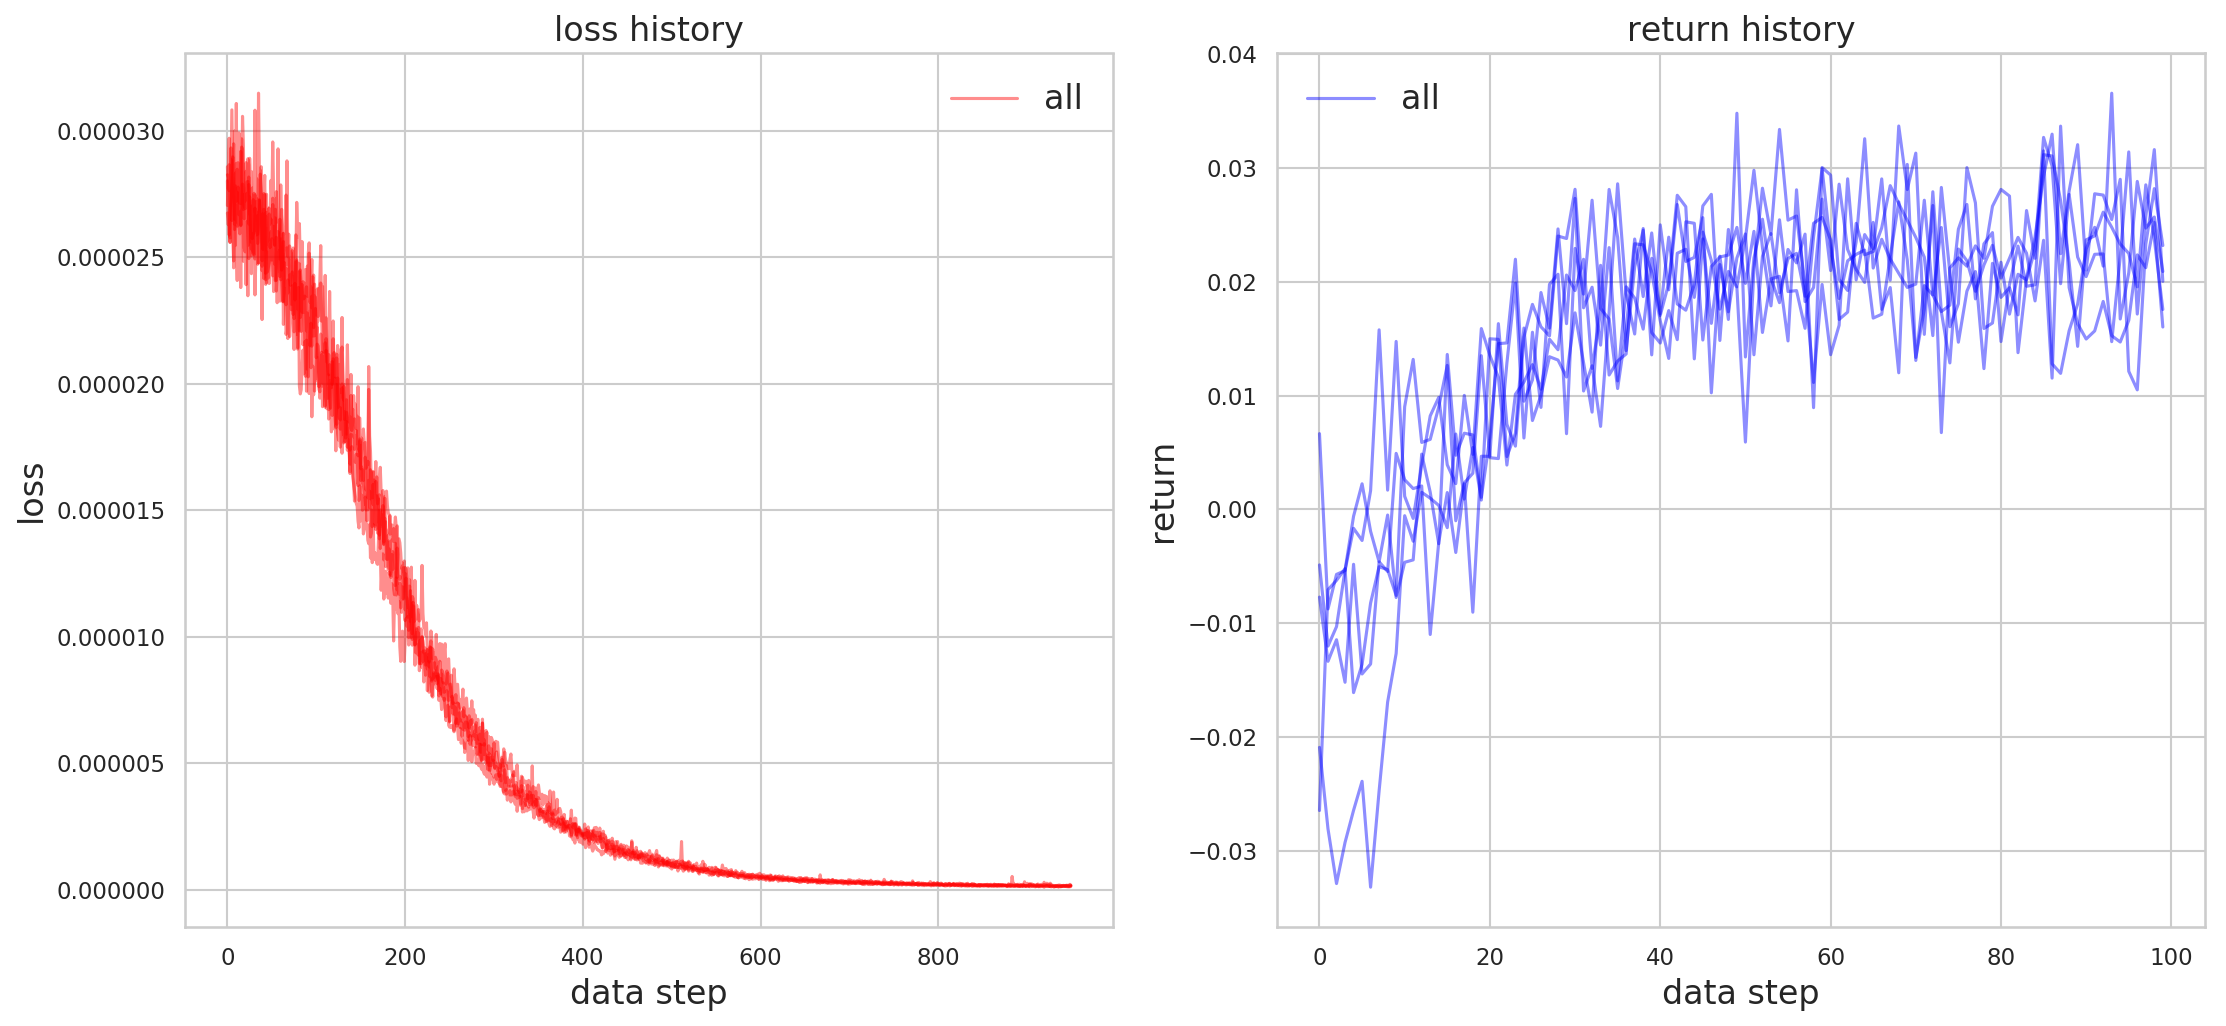

acquired action
action =  [90 59 37 30 40  1 40 20  7 78]
return [ 3.708e-03 -8.530e-02 -1.852e-03 -4.221e-08  3.449e-02  8.125e-03
  5.871e-02  4.648e-02  4.150e-02  0.000e+00]
param distribution in model


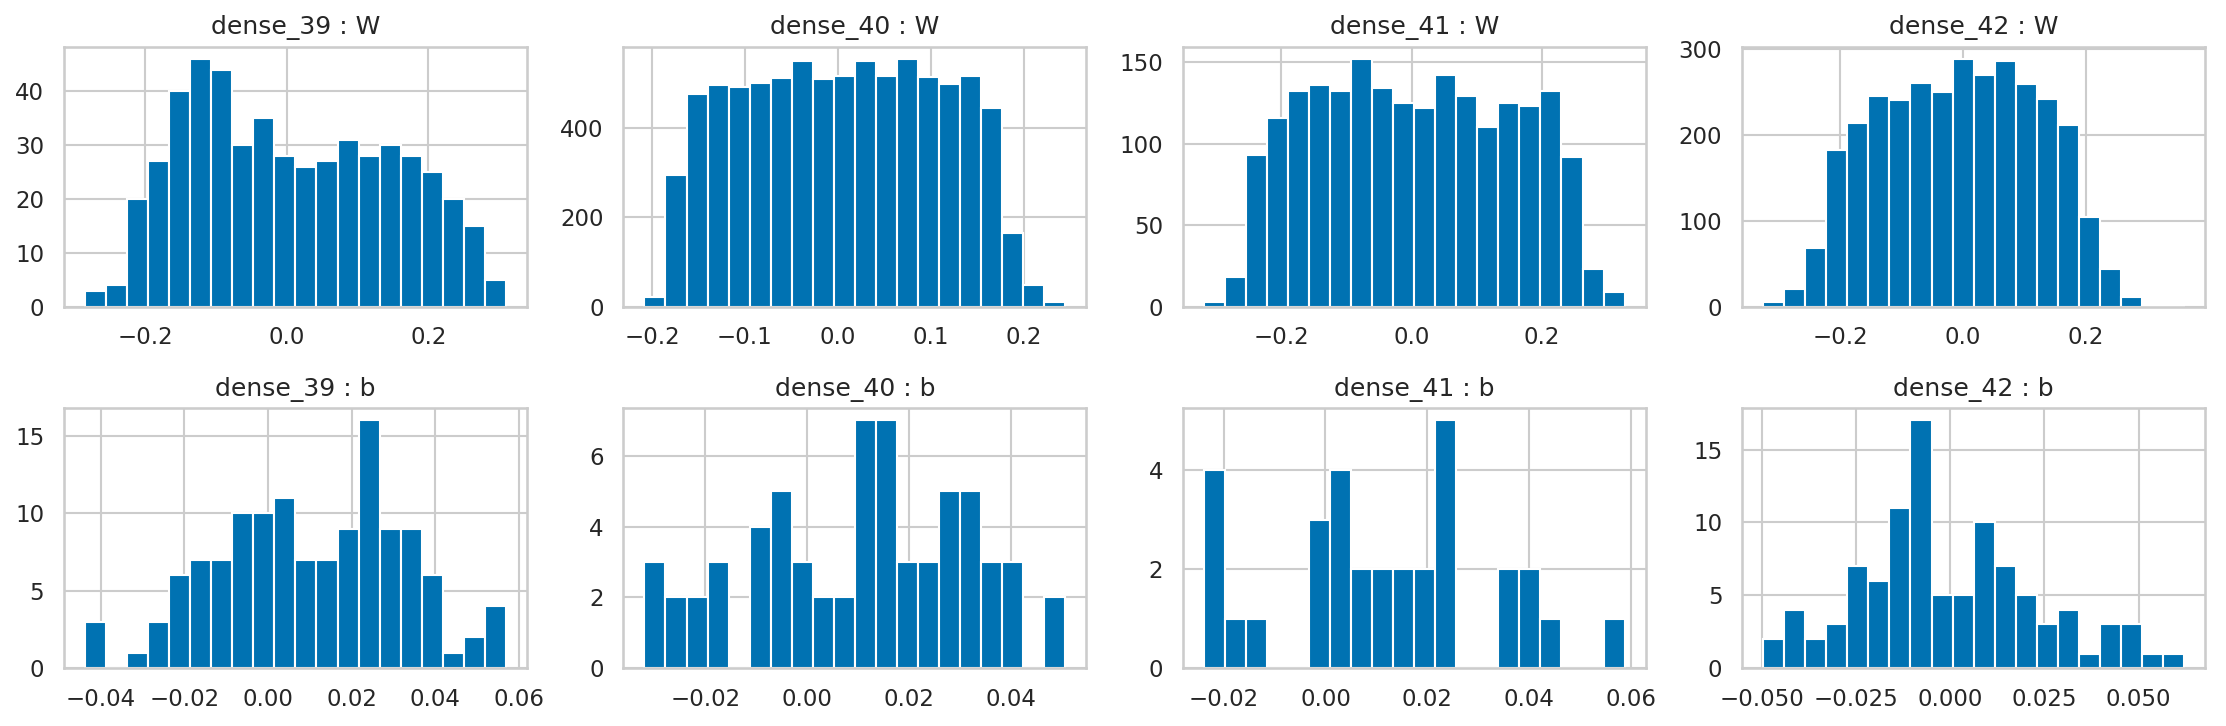

In [22]:
import DQN  # original DRL code
importlib.reload(DQN)
from keras import optimizers

env = Env_CAPM.CAPM(returns=returns, sigmas=sigmas, 
                    action_default_mode='discrete',
                    gen_automatic=True)

model = DQN.gen_model(
    input_shapes=env.shapes(), n_outputs=10 ** env.n_assets, 
    hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0,
    duel=False, duel_value_dim=16, duel_advantage_dim=16
)

#df = pd.DataFrame()
for lr, alpha in itertools.product([1e-4,], [1.0,]):
    print('======================================================')
    print('lr={}, alpha={}'
          .format(lr, alpha))
    
    tester = DQN.Tester(env, model, name='DQN_03')
    #n_trials = 3
    #n_steps = 10000
    tester.test(
        n_trials=n_trials, n_steps=n_steps,
        training_interval=10, n_batches=10, batch_size=256, alpha=alpha, 
        target_update_interval=20, doubleQ=False,
        gamma=1.0, optimizer=optimizers.Adam(lr, clipnorm=10),
        epsilon_start=1.0, epsilon_end=1.0, epsilon_interval=n_steps,
        boltzmann=False, 
        verbose=False, verbose_interval=10, evaluate_interval=100, 
        get_log=False)

    #viz = DQN.Visualizer()
    #viz.viz_action_history(tester.trainer, state_valuation=lambda x:np.ravel(x[0][:, 0]),data_span=100,  
    #                           cmap='jet', alpha=1.0, s=1.0)
    #viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['alpha'] = alpha
        df_temp['Agent'] = 'DQN'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

testers['DQN'] = tester
df.to_csv(tester.name + '.csv')

lr=0.0001, n_advantages=1, mult_critic=0.1, mult_entropy=0.0001
start testing... :  2019-10-29 04:59:32.542181
start 0/5 th trial...


100%|██████████| 10000/10000 [01:16<00:00, 130.90it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [01:17<00:00, 128.23it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [01:19<00:00, 125.09it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [01:20<00:00, 123.62it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [01:22<00:00, 120.57it/s]


end testing... :  2019-10-29 05:06:22.853725
loss and reward history


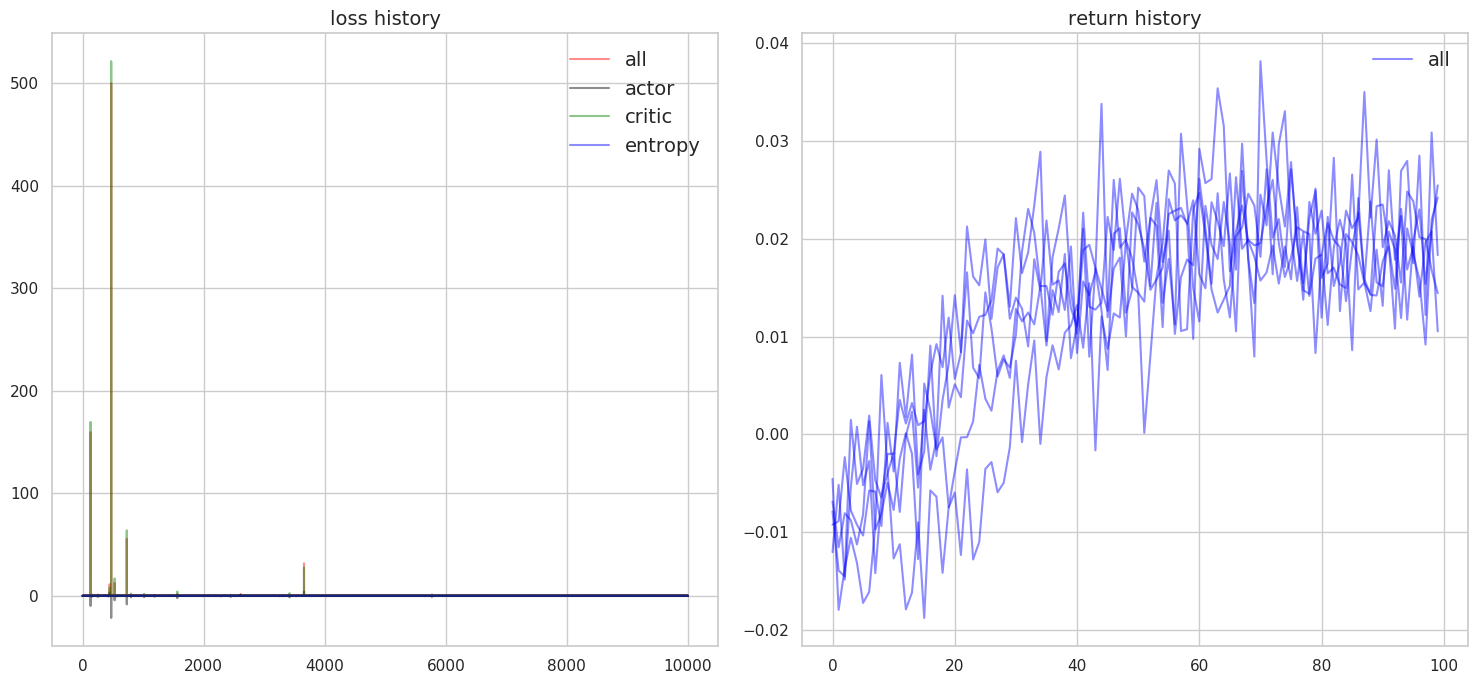

acquired action
action =  [7.889e-01 1.203e-02 9.288e-04 9.675e-01 2.641e-01 1.076e-01 9.929e-01
 4.486e-04 3.102e-04 9.833e-01]
return [ 5.052e-02 -9.780e-05  8.305e-03 -8.181e-05  4.388e-02  7.468e-02
  3.572e-02  1.082e-01  1.013e-01  2.082e-02]
param distribution in model


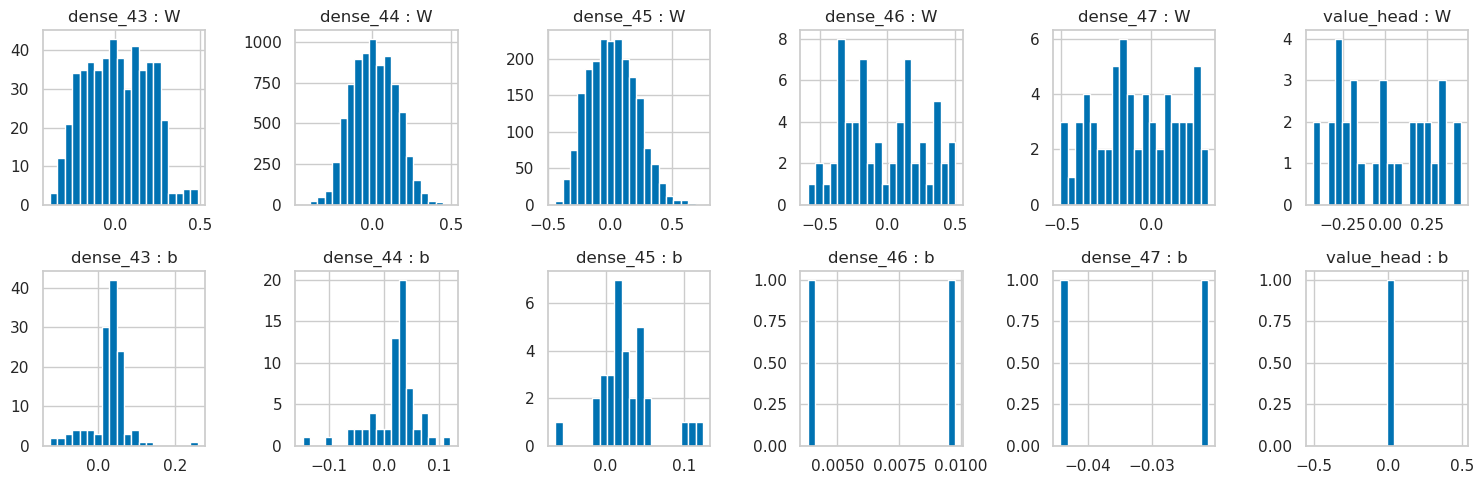

In [23]:
import A2C_continuous  # original DRL code
from keras import optimizers

env = Env_CAPM.CAPM(returns=returns, sigmas=sigmas, 
                    action_default_mode='continuous',
                    gen_automatic=True)

mu_min = 0.0
mu_max = 1.0
sigma_max = (mu_max - mu_min) / 3

model = A2C_continuous.gen_model(input_shapes=env.shapes(), n_outputs=env.n_assets, \
                                 hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, \
                                 mu_min=mu_min, mu_max=mu_max, 
                                 va_min=(0.00001)**2, va_max=sigma_max**2, 
                                 input_reg=False, input_min=0, input_max=1)

#df = pd.DataFrame()
for lr, n_advantages, mult_critic, mult_entropy in itertools.product(
    [1e-4,], [1,], [0.1,], [0.0001,]):
    print('======================================================')
    print('lr={}, n_advantages={}, mult_critic={}, mult_entropy={}'
          .format(lr, n_advantages, mult_critic, mult_entropy))

    tester = A2C_continuous.Tester(env, model, name='A2C_03',
                                   val_min=mu_min-3*sigma_max, val_max=mu_max+3*sigma_max)
    #n_trials = 3
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps, n_advantages=n_advantages,
               gamma=1.0, optimizer=optimizers.Adam(lr=lr),
               mult_actor=1.0, mult_critic=mult_critic, mult_entropy=mult_entropy,
               verbose=False, verbose_interval=100, evaluate_interval=100, 
               get_log=False)

    #viz = A2C_continuous.Visualizer()
    #viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
    #                       cmap='jet', alpha=1.0, s=1.0)

    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['n_advantages'] = n_advantages
        #df_temp['mult_critic'] = mult_critic
        #df_temp['mult_entropy'] = mult_entropy
        df_temp['Agent'] = 'A2C'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

testers['A2C'] = tester
df.to_csv(tester.name + '.csv')

lr_p=0.0001, lr_v=0.001, boltzmann=False, sigma_end=1.0, tau_end=1
start testing... :  2019-10-29 05:06:31.260887
start 0/5 th trial...


100%|██████████| 10000/10000 [03:42<00:00, 44.73it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [03:49<00:00, 43.96it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [03:56<00:00, 41.88it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [04:03<00:00, 41.39it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [04:10<00:00, 40.53it/s]


end testing... :  2019-10-29 05:26:57.678822
loss and reward history


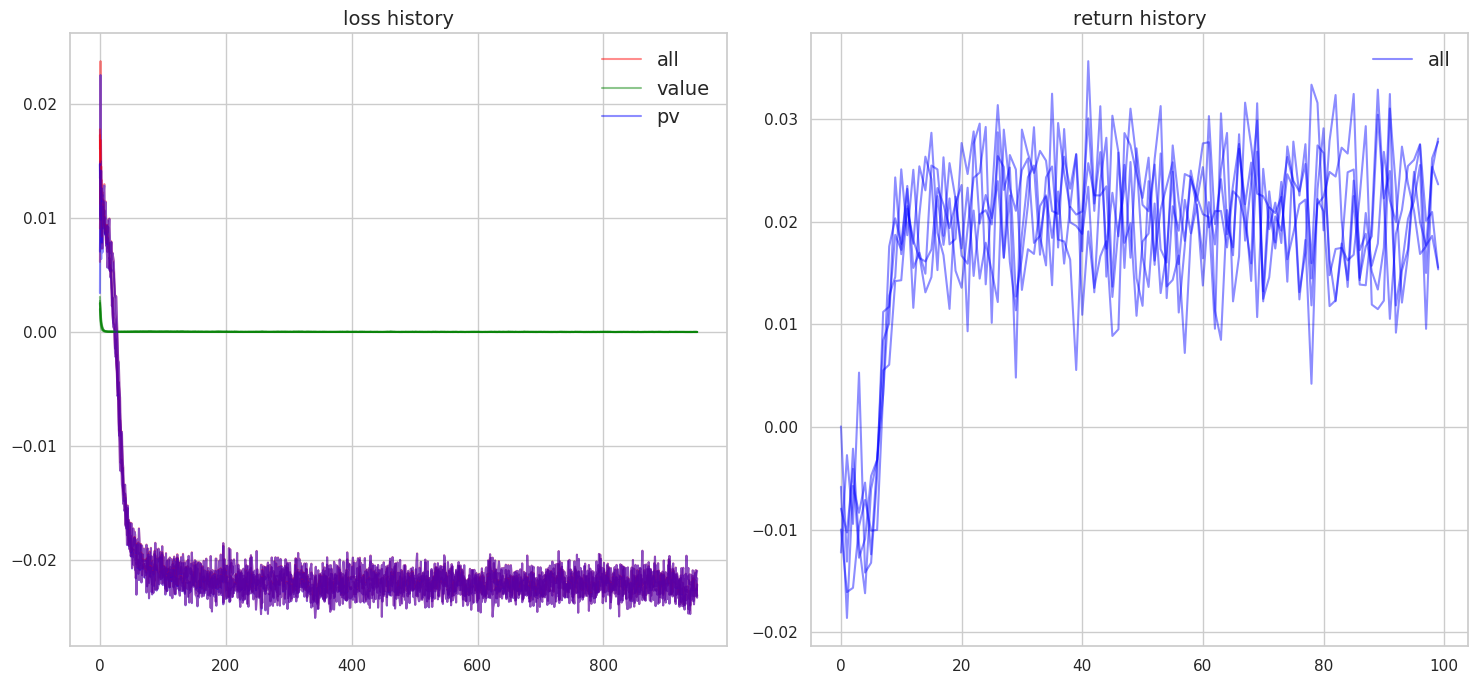

acquired action
action =  [2.652e-06 2.605e-01 5.960e-08 9.320e-01 8.970e-06 6.911e-01 7.752e-05
 1.897e-02 0.000e+00 3.742e-01]
return [-7.574e-07  4.139e-02  4.819e-02 -8.571e-05 -5.016e-02 -2.996e-05
 -2.789e-02 -4.330e-02 -6.426e-03 -1.456e-05]
param distribution in model_policy


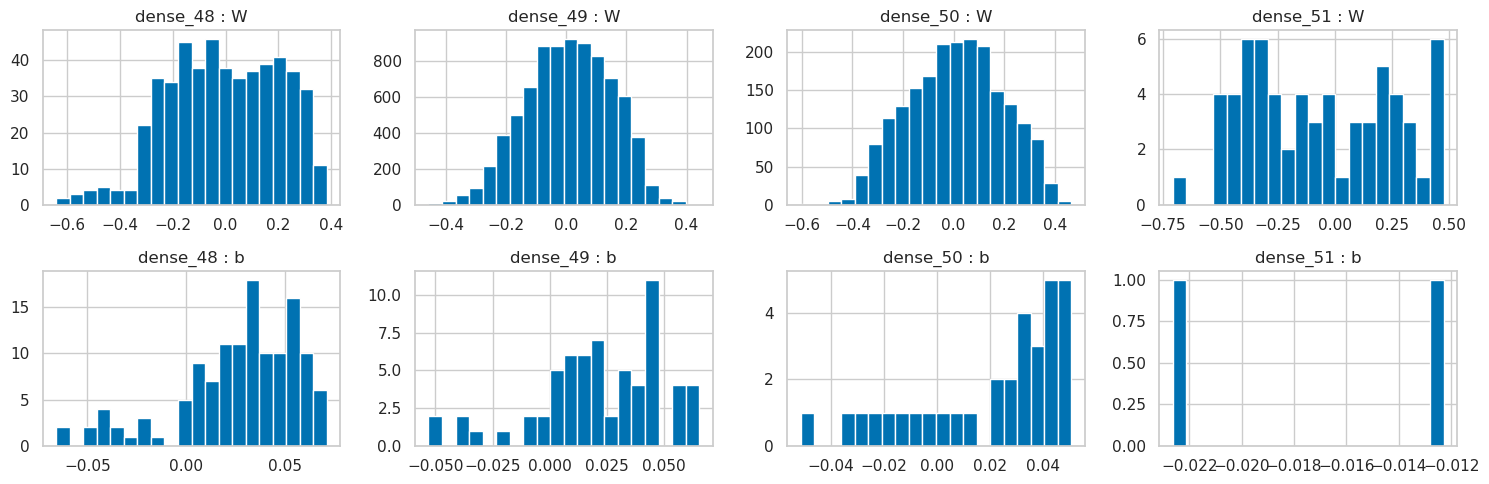

param distribution in model_value


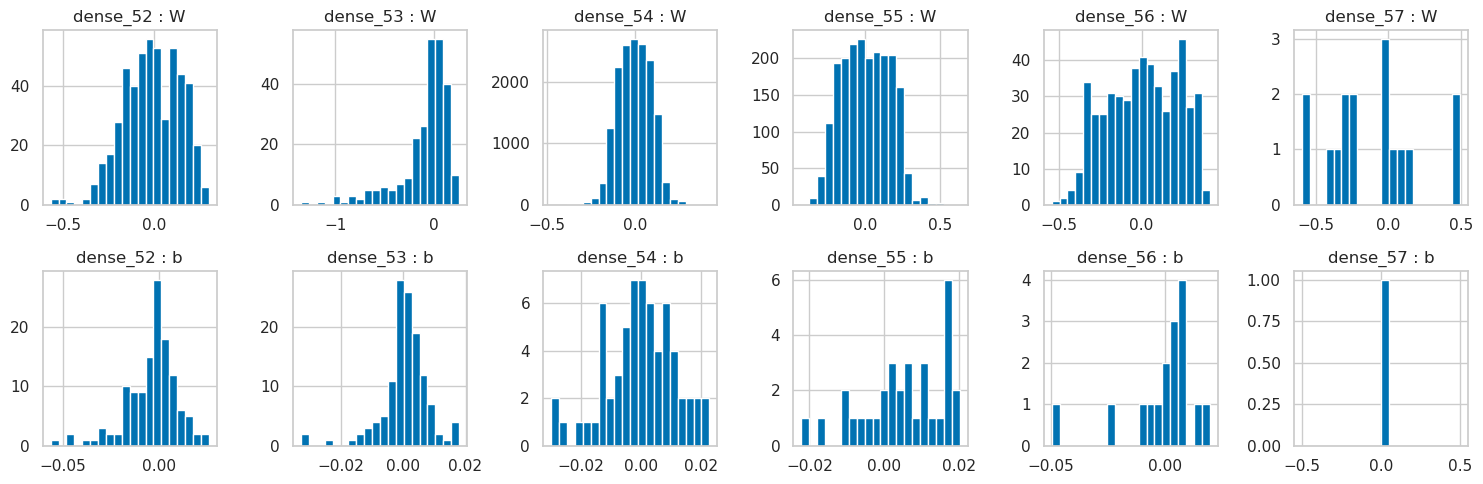

In [24]:
import DDPG  # original DRL code
importlib.reload(DDPG)
from keras import optimizers

env = Env_CAPM.CAPM(returns=returns, sigmas=sigmas, 
                    action_default_mode='continuous',
                    gen_automatic=True)

action_min = 0.0
action_max = 1.0
sigma_max = (action_max - action_min) / 3

model_policy = DDPG.gen_model_policy(state_shapes=env.shapes(), n_actions=env.n_assets, 
                                     hidden_dims=[128, 64, 32], 
                                     reg_l1=0.0, reg_l2=0.0, 
                                     action_min=action_min, action_max=action_max, 
                                     batch_norm_input=False, 
                                     state_reg=False, state_min=0, state_max=10)

model_value = DDPG.gen_model_value(state_shapes=env.shapes(), n_actions=env.n_assets, \
                                   hidden_action_dims=[128,], 
                                   hidden_state_dims=[128,],
                                   hidden_dims=[64, 32, 16],
                                   reg_l1=0.0, reg_l2=0.0,
                                   batch_norm_state_hidden=False)


#df = pd.DataFrame()
for lr_p, lr_v, boltzmann, sigma_end, tau_end in itertools.product(
    [1e-4,], [1e-3,], [False], [1.0,], [1,]):
    print('======================================================')
    print('lr_p={}, lr_v={}, boltzmann={}, sigma_end={}, tau_end={}'
          .format(lr_p, lr_v, boltzmann, sigma_end, tau_end))

    tester = DDPG.Tester(env, model_policy, model_value, name='DDPG_03', 
                         val_min=action_min, val_max=action_max)
    #n_trials = 3
    #n_steps = 10000
    tester.test(n_trials=n_trials,
                gamma=1.0,
                n_steps=n_steps, training_interval=10, n_batches=10, batch_size=256,
                target_update_interval_policy=20, target_update_interval_value=20,
                tau_policy=0.5, tau_value=0.5,
                optimizer_pv=optimizers.Adam(lr=lr_p), optimizer_value=optimizers.Adam(lr=lr_v),
                sigma_start=sigma_max, sigma_end=sigma_max*sigma_end, sigma_interval=n_steps,
                boltzmann=boltzmann, tau_start=10, tau_end=tau_end, tau_interval=n_steps, n_samples=64,
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                wampup_steps=500, 
                get_log=False)

    #viz = DDPG.Visualizer()
    #viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
    #                           cmap='jet', alpha=1.0, s=1.0)
    #viz.viz_Q_history(trainer=tester.trainer, 
    #                  state_valuation=lambda x:np.ravel(x[0][:, 0]), 
    #                  action_valuation=lambda x:np.ravel(x[:, 0]),
    #                  data_span_exp=100, data_span_eva=100,)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr_p'] = lr_p
        #df_temp['lr_v'] = lr_v
        #df_temp['boltzmann'] = boltzmann
        #df_temp['sigma_end'] = sigma_end
        #df_temp['tau_end'] = tau_end
        df_temp['Agent'] = 'DDPG' 

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

testers['DDPG'] = tester
df.to_csv(tester.name + '.csv')

In [25]:
df.to_csv('03' + '.csv')
pd.options.display.precision = 4
ids = ['Agent']
df[df['t'].max()*0.9<=df['t']].groupby(ids)['return'].describe()

count    mean     std     min     25%     50%     75%     max
Agent                                                               
A2C     50.0  0.0193  0.0050  0.0092  0.0156  0.0193  0.0222  0.0309
DDPG    50.0  0.0208  0.0056  0.0092  0.0170  0.0211  0.0253  0.0324
DQN     50.0  0.0223  0.0053  0.0105  0.0186  0.0225  0.0254  0.0365

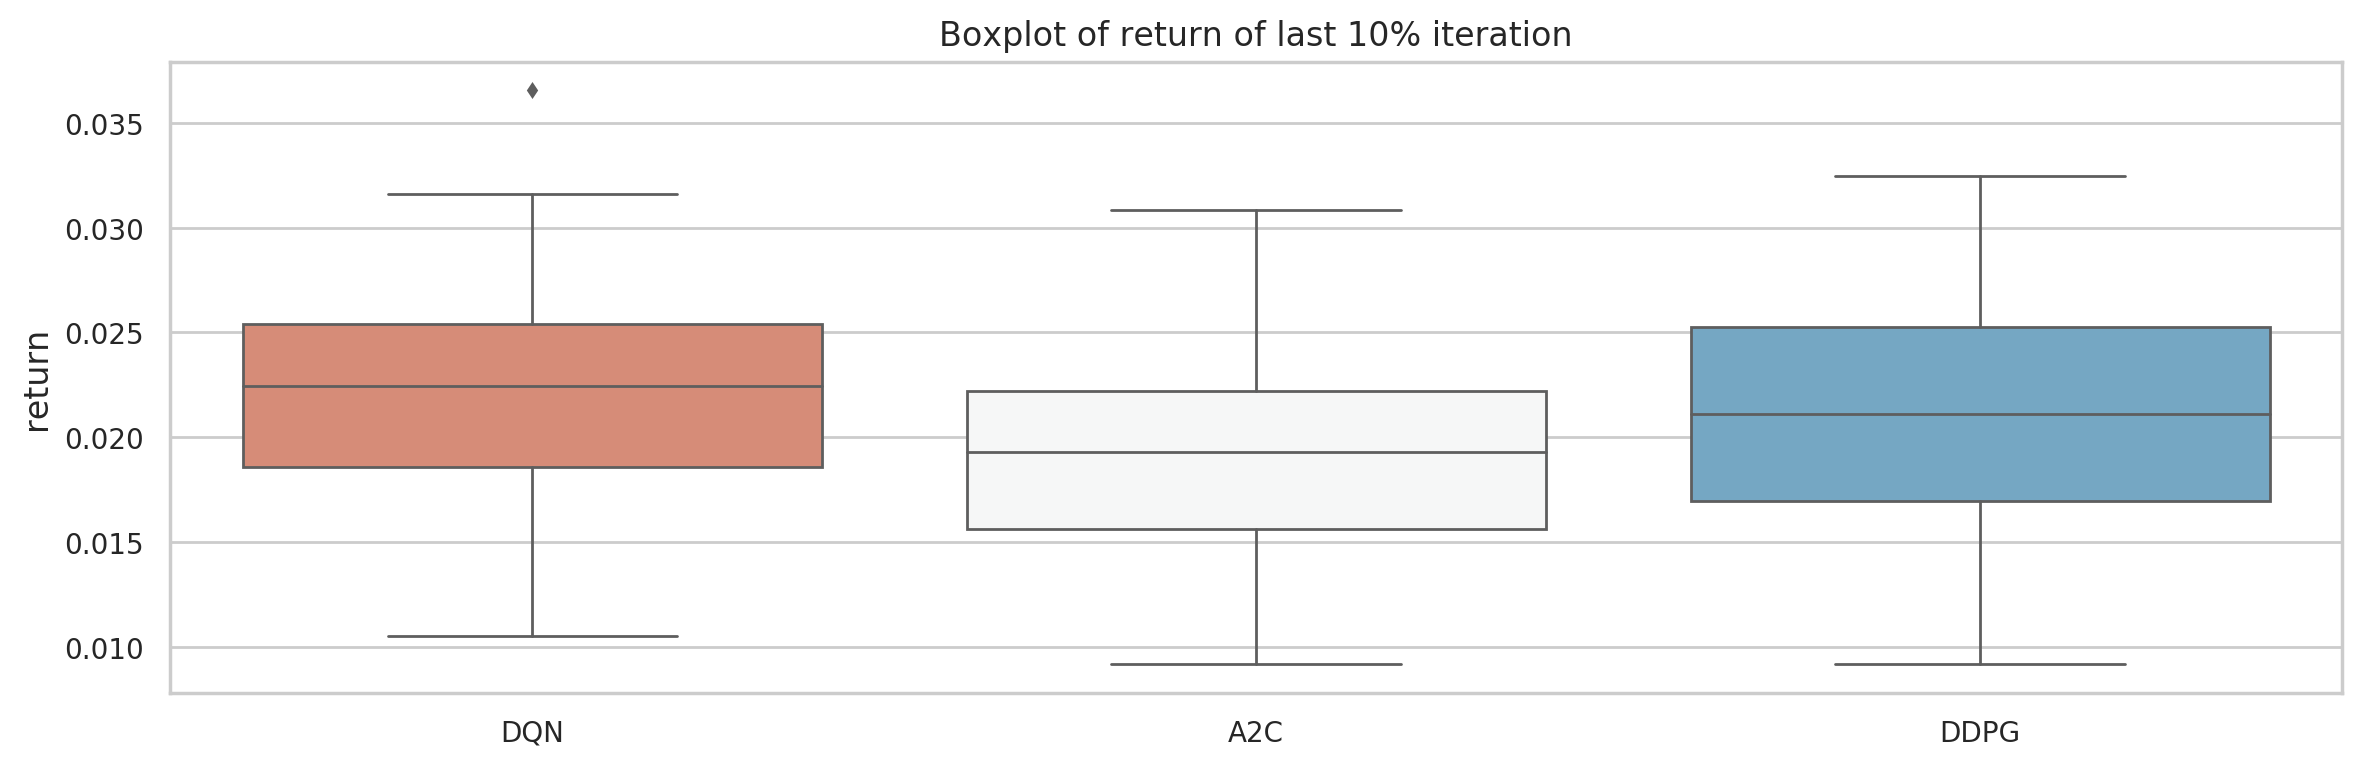

In [26]:
sns.set_style("whitegrid")
sns.set_context("notebook")

plt.figure(figsize=(12, 4), dpi=200)

sns.boxplot(data=df[df['t'].max()*0.9<=df['t']], x='Agent', y='return', orient='v', fliersize=3.0, linewidth=1.0, palette='RdBu')

plt.title('Boxplot of return of last 10% iteration', fontsize=12)
plt.xlabel('', fontsize=12)
plt.ylabel('return', fontsize=12)
plt.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


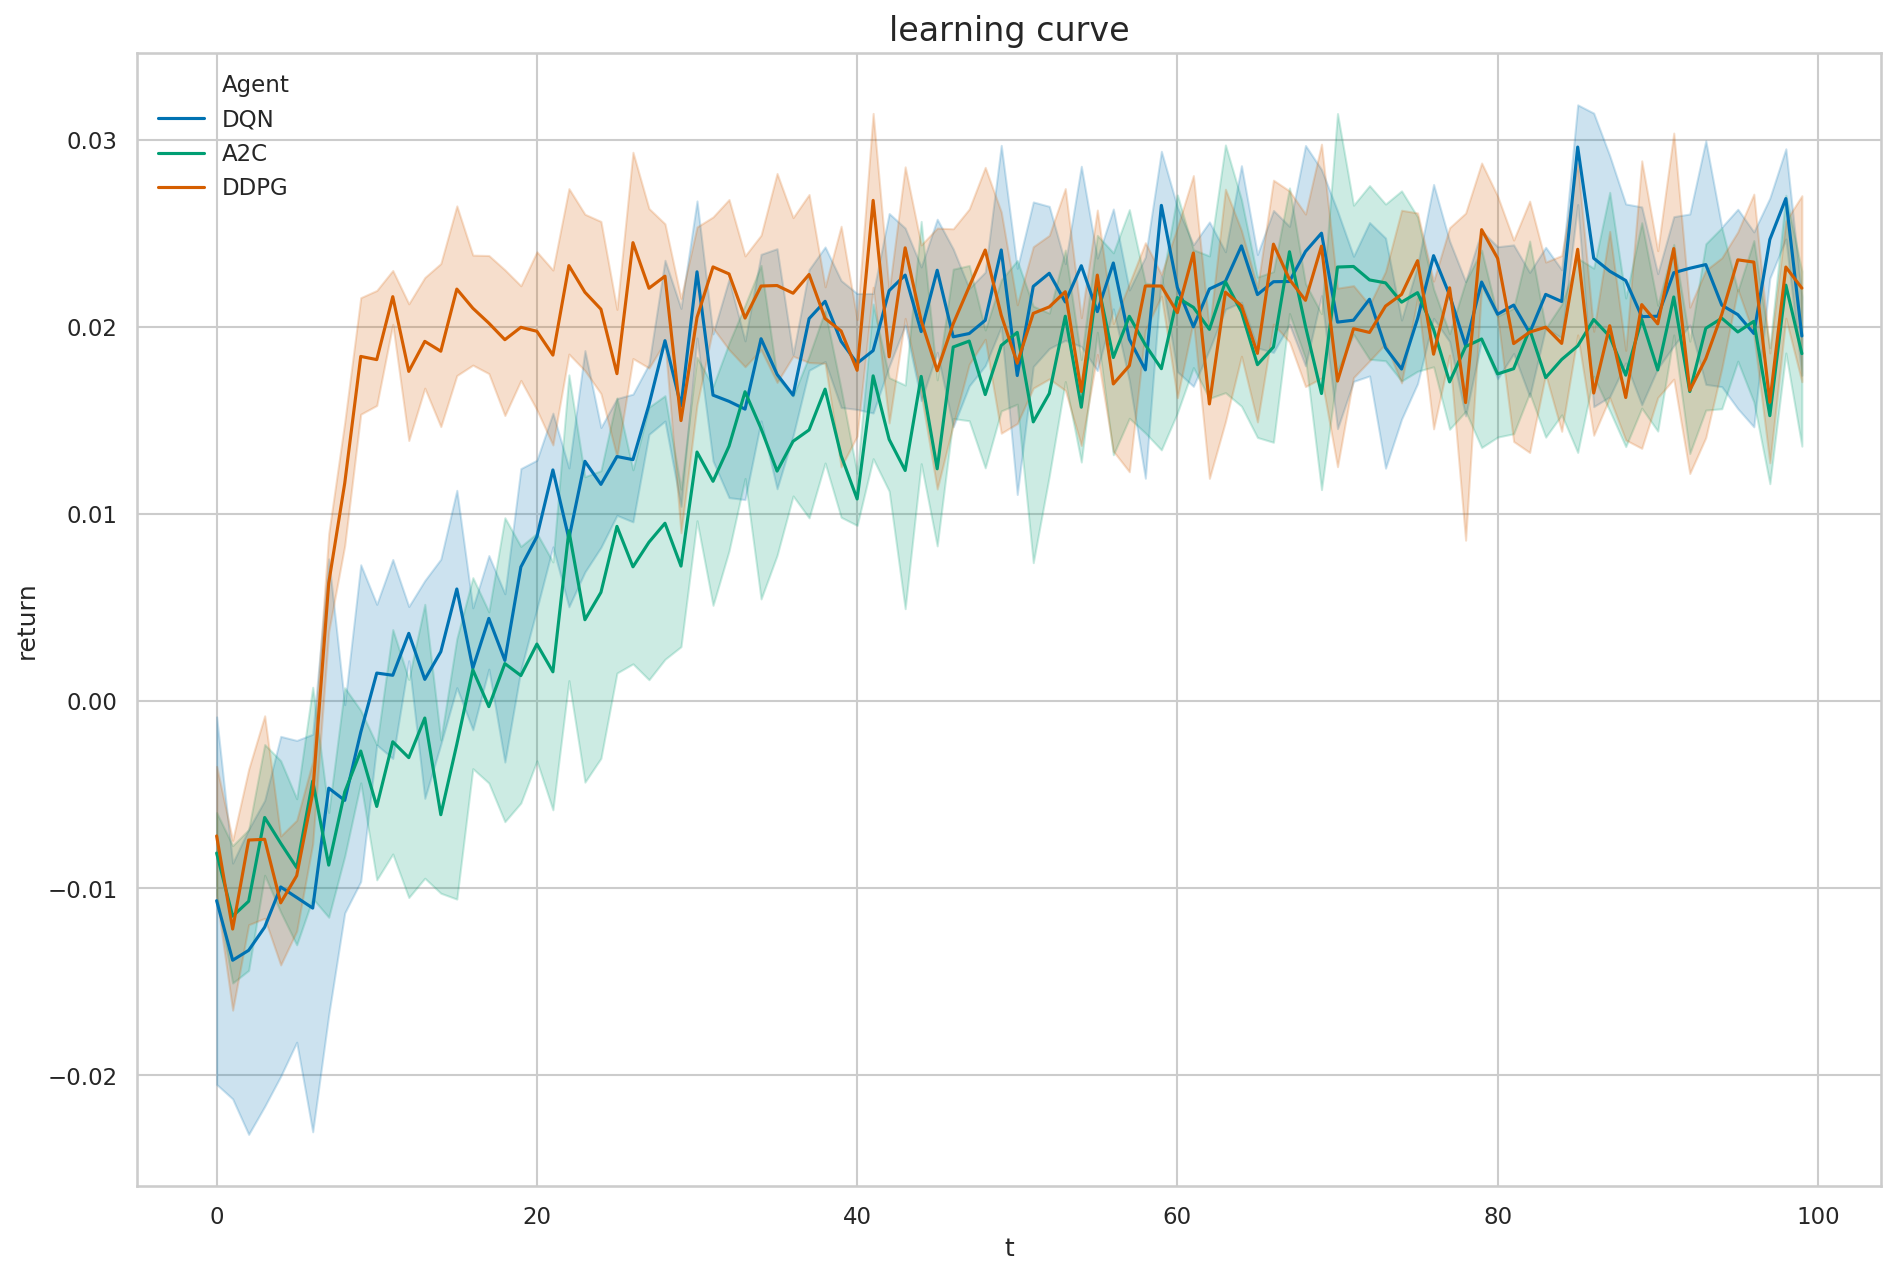

In [27]:
fig = plt.figure(figsize=(15, 10), dpi=150)
sns.lineplot(x='t', y='return', hue='Agent', data=df)
plt.title('learning curve', size=16)
plt.show()

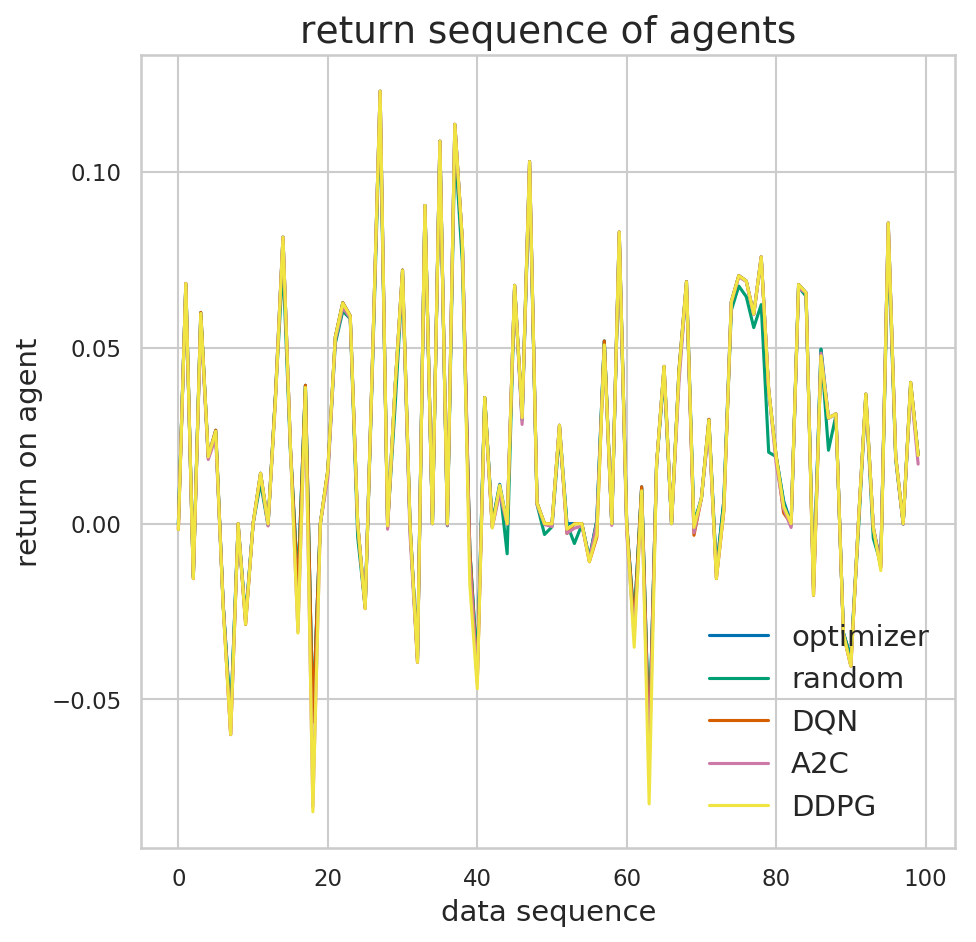

In [28]:
# 性能検証

env_test = Env_CAPM.CAPM()  # gen_parametersはオフ．

returns = {'optimizer':[], 'random':[], 'DQN':[], 'A2C':[], 'DDPG':[]}


for _ in range(100):
    env_test.gen_parameters()
    env_test.returns[1:] = env_test.returns[0]  # 全エージェント上の条件を揃える（randomの評価用）
    env_test.sigmas[1:] = env_test.sigmas[0]
    #print(env_test.returns)
    
    action = testers['DQN'].trainer.agent.get_action(env_test.state(), greedy=True)
    action = env_test.convert_action(action)
    returns['DQN'].append(env_test.step(action)[1][0, 0])
    
    action = testers['A2C'].trainer.agent.get_action(env_test.state(), greedy=True)
    returns['A2C'].append(env_test.step(action)[1][0, 0])

    action = testers['DDPG'].trainer.agent.get_action(env_test.state(), greedy=True)
    returns['DDPG'].append(env_test.step(action)[1][0, 0])
    
    # random action
    action = np.random.uniform(size=(env_test.n_agents, env_test.n_assets))
    action = action / action.sum(axis=-1, keepdims=True)
    returns['random'].append(np.max(env_test.step(action)[1][:, 0]))
    
    # optimal action
    returns['optimizer'].append(env_test._normal_optimize()[0])
    

reutrns = {key:np.array(returns[key]) for key in returns.keys()}  

fig = plt.figure(figsize=(7, 7), dpi=150)
for key in returns.keys():
    plt.plot(returns[key], label=key)
    
plt.title('return sequence of agents', size=18)
plt.xlabel('data sequence', size=14)
plt.ylabel('return on agent', size=14)
plt.legend(fontsize=14)
plt.show()

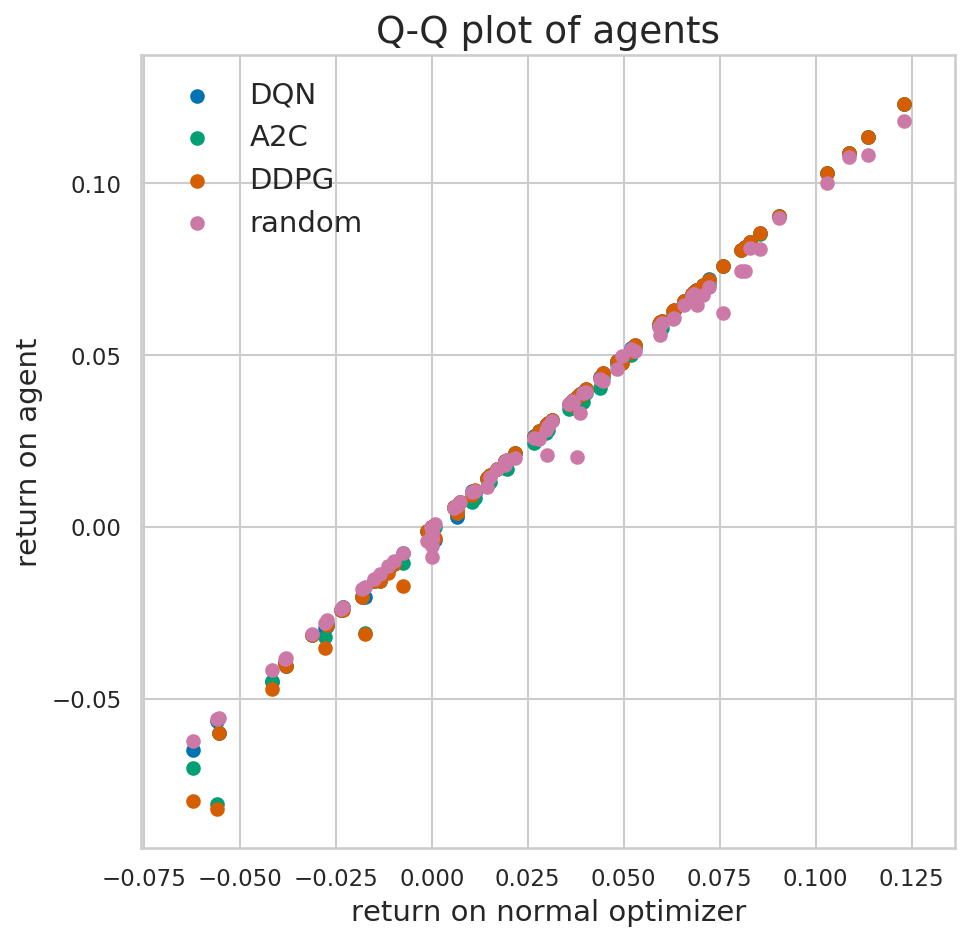

In [29]:
fig = plt.figure(figsize=(7, 7), dpi=150)
plt.scatter(x=returns['optimizer'], y=returns['DQN'], label='DQN')
plt.scatter(x=returns['optimizer'], y=returns['A2C'], label='A2C')
plt.scatter(x=returns['optimizer'], y=returns['DDPG'], label='DDPG')
plt.scatter(x=returns['optimizer'], y=returns['random'], label='random')
plt.title('Q-Q plot of agents', size=18)
plt.xlabel('return on normal optimizer', size=14)
plt.ylabel('return on agent', size=14)
plt.legend(fontsize=14)
plt.show()